# Installs

In [2]:
import os,sys

os.path.dirname(sys.executable)

'/raid/AICOE/aviv/envs/bin'

In [3]:
#@markdown Enter the DAGsHub repository owner name:
DAGSHUB_REPO_OWNER= "aviv.ples" #@param {type:"string"}

#@markdown Enter the DAGsHub repository name:
DAGSHUB_REPO_NAME= "sokoban-rl" #@param {type:"string"}

#@markdown Enter the username of your DAGsHub account:
DAGSHUB_USER_NAME = "aviv.ples" #@param {type:"string"}

DAGSHUB_TOKEN = "eb1587fdb4b2ef917e728f506d8bc187a67d1c93"

In [4]:
# %%capture
# !apt-get update
# !apt-get install -y xvfb ffmpeg freeglut3-dev
# !pip install 'imageio==2.4.0'
# !pip install gym==0.22
# !pip install pygame
# !apt-get install python-opengl -y
# !pip install pyvirtualdisplay
# !pip install piglet
# !pip install gym_sokoban
# !git clone https://github.com/avivg7/sokoban-so.git
# !unzip /content/sokoban-so/Compress.zip

# !pip install mlflow dagshub

# Imports

In [5]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
from soko_pap import *
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import pyvirtualdisplay
import imageio
import IPython
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
import pickle
import imageio
from base64 import b64encode

In [6]:
import warnings
warnings.filterwarnings("ignore")
%autosave 5

# Display utils
The cell below contains the video display configuration. No need to make changes here.

In [7]:
# def embed_mp4(filename):
#   """Embeds an mp4 file in the notebook."""
#   video = open(filename,'rb').read()
#   b64 = base64.b64encode(video)
#   tag = '''
#   <video width="640" height="480" controls>
#     <source src="data:video/mp4;base64,{0}" type="video/mp4">
#   Your browser does not support the video tag.
#   </video>'''.format(b64.decode())

#   return IPython.display.HTML(tag)
# display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

Function - given an environment it will print us the details about observation, actions, agent's position and boxes locations

In [8]:
def print_env_det(env):
  print(f'Observation space: {env.observation_space}'
      f'\nAction space: {env.action_space}'
      f'\nPlayer position:{env.player_position}'
      f'\nBox location: {find_box_location(env)}')

Function - given an environment it will return the indexes position and boxes locations

In [9]:
def find_box_location(env):
    idx = np.argmax(env.room_state == 4)
    if env.room_state.flat[idx] == 4:
        return np.unravel_index(idx, env.room_state.shape)
    return None

In [10]:
# MLFLOW

import mlflow
import os

os.environ['MLFLOW_TRACKING_USERNAME'] = DAGSHUB_USER_NAME
os.environ['MLFLOW_TRACKING_PASSWORD'] = DAGSHUB_TOKEN
os.environ['MLFLOW_TRACKING_URI'] = f'https://dagshub.com/{DAGSHUB_REPO_OWNER}/{DAGSHUB_REPO_NAME}.mlflow'

print(os.getenv('MLFLOW_TRACKING_URI'))

https://dagshub.com/aviv.ples/sokoban-rl.mlflow


# Functions

## Pre-processing

Set the PyTorch device to either "cuda" if GPU is available, or CPU otherwise. If you GPU is available, using it can significantly speed up the computations required for training deep neural networks.

In [11]:
device = torch.device("cuda:14" if torch.cuda.is_available() else "cpu")

The replay memory buffer is used to store the experiences of an agent while it runs within the env. We will use the buffer sampling transitions from the it and using them to update the network's parameters during the training.

In [13]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


DQN is a convolutional neural network model. The CNN extracts features from the input state, and then passes the feature vector through a fully connected network to produce a Q-value for each possible action.

In [14]:
class DQN(nn.Module):
    """
    Convolutional Neural Net with 3 conv layers and two linear layers
    """
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

Rescales each frame to size 112x112 with grayscale. The resulting observation is a NumPy array with shape (112, 112, 1).

In [15]:
class Rescale112x112(gym.ObservationWrapper):
    """
    Downsamples/Rescales each frame to size 112x112 with greyscale
    """
    def __init__(self, env=None):
        super(Rescale112x112, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(112, 112, 1), dtype=np.uint8)

    def observation(self, obs):
        return Rescale112x112.process(obs)

    @staticmethod
    def process(frame):
        if frame.shape == (240, 256, 3):
            img = np.reshape(frame, [240, 256, 3]).astype(np.float32)
            img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
            resized_screen = cv2.resize(img, (112, 112), interpolation=cv2.INTER_AREA)
            x_t = np.reshape(resized_screen, [112, 112, 1])
        elif frame.shape == (112, 112, 3):
            # image normalization on RBG
            img = frame[:, :, 0] * 0.299 + frame[:, :, 1] * 0.587 + frame[:, :, 2] * 0.114
            x_t = np.reshape(img, [112, 112, 1])
        else:
            assert False, "Unknown resolution."
        return x_t.astype(np.uint8)


To reduce computation time preserving important visual information in the observations, we repeat each action over skip number of frames and return only every skip-th frame while taking the maximum pixel values across the skipped frames.

In [16]:
class MaxAndSkipEnv(gym.Wrapper):
    """
    Each action of the agent is repeated over skip frames
    return only every `skip`-th frame
    """
    def __init__(self, env=None, skip=4):
        super().__init__(env)
        self._obs_buffer = deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.maximum(self._obs_buffer[0], self._obs_buffer[1])
        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        self._obs_buffer.clear()
        obs = self.env.reset(**kwargs)
        self._obs_buffer.append(obs)
        return obs


Convert each observation to a PyTorch tensor

In [17]:
class ImageToPyTorch(gym.ObservationWrapper):
    """
    Each frame is converted to PyTorch tensors
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)



Create a buffer of size n_steps that stores every k-th frame of the environment observation.

In [18]:
class BufferWrapper(gym.ObservationWrapper):
    """
    Only every k-th frame is collected by the buffer
    """
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer


Normalize pixel values in each observation to be in the range of 0 to 1.

In [19]:
class PixelNormalization(gym.ObservationWrapper):
    """
    Normalize pixel values in frame --> 0 to 1
    """
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0

Create proper env, post all pre-processing:

In [20]:
def create_env(env):
    env = MaxAndSkipEnv(env)
    env = Rescale112x112(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    env = PixelNormalization(env)
    return env

## Helper Functions

### Convergence Threshold
If the policy is such that in the previous 20 iterations both the rewards sum and the duration averages has stayed appx. the same as the last one, the policy has convereged. In addtion, we demand that the latest reward will be over 5, since in trial and error iterations we have seen that the final reward for the optimal solution is set around 6.

In [21]:
# def check_convergence(i_episode, episode_rewards, episode_durations, n=20, reward_threshold=4):
#     """
#     Check if the policy has converged based on the specified decision rule.

#     Args:
#     rewards (list[float]): List of rewards for each episode.
#     durations (list[int]): List of episode durations (i.e., count of steps needed to complete each episode).

#     Returns:
#     bool: True if the policy has converged; False otherwise.
#     """

#     # Check if there are at least n episodes to compare.
#     if len(episode_rewards) < n + 1:
#         return False
#     if np.mean(episode_rewards[-n:]) < reward_threshold:
#         return False
#     print(f"Policy has converged after {i_episode} episodes! The final episode_rewards sum is {episode_rewards[-1]}, and the final duration is {episode_durations[-1]}")
#     return True
def exponential_moving_average(data, alpha=0.1):
    ema = [data[0]]
    for i in range(1, len(data)):
        ema.append(alpha * data[i] + (1 - alpha) * ema[-1])
    return ema

def check_convergence(i_episode, episode_rewards, episode_durations, n=20, initial_reward_threshold=8, variance_threshold=1.0, duration_threshold=17):
    if len(episode_rewards) < n + 1:
        return False

    # Calculate the exponential moving averages for rewards and durations
    ema_rewards = exponential_moving_average(episode_rewards)
    ema_durations = exponential_moving_average(episode_durations)

    mean_reward = np.mean(ema_rewards[-n:])
    reward_variance = np.var(ema_rewards[-n:])
    mean_duration = np.mean(ema_durations[-n:])

    # Adaptive threshold based on the progress of training
    adaptive_reward_threshold = max(initial_reward_threshold - i_episode * 0.01, 4)

    if mean_reward < adaptive_reward_threshold or reward_variance > variance_threshold or mean_duration > duration_threshold:
        return False

    print(f"Policy has converged after {i_episode} episodes! The final episode_rewards sum is {episode_rewards[-1]}, and the final duration is {episode_durations[-1]}")
    return True


### Optimize Model

In [22]:
def optimize_model(batch_size, gamma, optimizer, policy_net, target_net, memory):
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()


### Plot Results

In [23]:
def plot_results(res_list, duration_mode=False, add_mean_and_std=False, save=False, run_name=None):
    if duration_mode:
        y = 'Duration'
    else:
        y = 'Rewards'
    fig = plt.figure(figsize=(20, 12))
    ax = fig.add_subplot(111)
    ax.set_xlabel('Episode', fontsize=14)
    ax.set_ylabel(y, fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.plot(res_list, color='#0072BD', linewidth=2)
    ax.grid(linestyle='--', linewidth=0.5, alpha=0.7)

    if add_mean_and_std:
        # Add mean and standard deviation to the plot
        res_mean = np.mean(res_list)
        res_std = np.std(res_list)
        ax.axhline(res_mean, color='#D95319', linestyle='--', linewidth=2, label='Mean')
        ax.fill_between(range(len(res_list)), res_list-res_std, res_list+res_std, color='#EDB120', alpha=0.2, label='Std Dev')
        ax.legend(loc='best', fontsize=12)
    if save:
        plt.savefig(f'results/{run_name}_{y}.png')
    plt.show()


### Select Action

In [24]:
def select_action(state, env, policy_net, epsilon = 0.1):
    sample = random.random()
    if sample > epsilon:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


### Model Utils

#### Load Existing Model

In [25]:
def load_model(model_name, policy_net):
    with open(f'models/{model_name}.pkl', 'rb') as f:
        state_dict = pickle.load(f)

    policy_net.load_state_dict(state_dict)
    return policy_net

#### Save Existing Model

In [26]:
def save_model(policy_net, model_name):
    state_dict = policy_net.state_dict()
    file_path = f"models/{model_name}.pkl"
    with open(file_path, 'wb') as f:
        pickle.dump(state_dict, f)
        print("Saved model!")

    return None

### Record Policy

In [27]:
import matplotlib.animation as animation

def record_policy(env, policy, max_steps=500, filename=''):
    state = env.reset()
    done = False
    steps = 0
    fig = plt.figure()
    ims = []
    while not done and steps < max_steps:
        im = env.render()
        ims.append([plt.imshow(im)])
        action = np.argmax(policy[state]) if state in policy else env.action_space().sample()
        next_state, reward, done, _ = env.step(action)
        state = next_state
        steps += 1
    im = env.render()
    ims.append([plt.imshow(im)])
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000);
    ani.save(filename);
    return

#### Display Video

In [28]:
def display_video(path):
    # Open the video file
    with open(path, 'rb') as f:
        video_data = f.read()

    # Base64 encode the video data
    encoded_video = b64encode(video_data).decode('utf-8')

    # Create the HTML string for displaying the video
    html = f'<video width="480" height="360" controls><source src="data:video/mp4;base64,{encoded_video}" type="video/mp4"></video>'

    # Display the video in the notebook
    return HTML(html)


### Reward manipulation
To shorten training times on this task, we added the a reward manipulation logic. In each reward caclulation we calculate the previous Manhatten distance between the box location and the target location (before the action), as well and the current distance (after the action). If the distance has decreased, than generally we assume that the action was a positive action, and give it a positive boost. Otherwise, we give it a negative boost. If the action completed the game, we give an additional boost.

In [29]:
# def apply_reward_manipulation(reward, box_position, next_box_position, end_goal_position, done):
#     """
#     Apply reward manipulation based on manhatten distance trend caused by the action
#     """
#     # If done, add another 1 point reward
#     if done:
#         return reward + 1

#     curr_distance = manhattan_distance(box_position, end_goal_position)
#     next_distance = manhattan_distance(next_box_position, end_goal_position)
#     manip_reward = reward + next_distance - curr_distance

#     # If the new distance is larger than the previous one (i.e. the move was wrong), give additional negative reward
#     if next_distance - curr_distance > 0:
#         manip_reward += 0.1
#     else:
#         manip_reward -= 0.5
#     return manip_reward
def apply_reward_manipulation(reward, box_positions, next_box_positions, end_goal_positions, done):
    # Initialize manipulated reward
    manip_reward = reward
        
    total_curr_distance = sum(min(manhattan_distance(box_pos, goal_pos) for goal_pos in end_goal_positions) for box_pos in box_positions)
    total_next_distance = sum(min(manhattan_distance(box_pos, goal_pos) for goal_pos in end_goal_positions) for box_pos in next_box_positions)
    
    if total_next_distance < total_curr_distance:
        manip_reward += 0.5  # Bonus for reducing total distance
    elif total_next_distance > total_curr_distance:
        manip_reward -= 0.5  # Penalty for increasing total distance

    return manip_reward


def manhattan_distance(agent_pos, box_pos):
      """
      Calculate the Manhattan distance between agent position and box position
      """
      return abs(agent_pos[0] - box_pos[0]) + abs(agent_pos[1] - box_pos[1])

In [30]:
# def find_end_goal_position(room_state):
#     row, col = np.where(room_state == 2)
#     # print(f"The end goal coordinates are {row[0], col[0]}")
#     return (row[0], col[0])

# def find_box_position(room_state):
#     row, col = np.where(room_state == 4)
#     # print(f"The box position coordinates are {row[0], col[0]}")
#     return (row[0], col[0])

def find_end_goal_positions(room_state):
    rows, cols = np.where(room_state == 2)
    return [(row, col) for row, col in zip(rows, cols)]

def find_box_positions(room_state):
    rows, cols = np.where(room_state == 4)
    return [(row, col) for row, col in zip(rows, cols)]

# Feeling the Env

## EX1 - FIX SCENARIO -  PUSH & PULL - ONE BOX

In [31]:
#=============== DO NOT DELETE ===============
random.seed(2)
sok = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=500)
# ============================================

Observation space: Box(0.0, 255.0, (112, 112, 3), float32)
Action space: Discrete(13)
Player position:[1 1]
Box location: (2, 2)


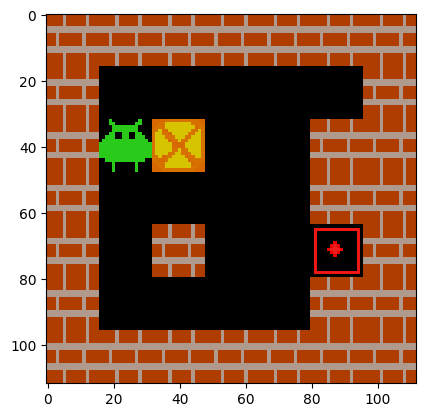

In [32]:
screen = sok.render(mode='rgb_array')
plt.imshow(sok.render('rgb_array'))
observation, reward, done, _ = sok.step(1)
print_env_det(sok)

### EX1 - Video test

In [38]:
# env = sok
# start_time = time.time()
# done = False
# iter = 0
# video_filename = 'imageio.mp4'
# with imageio.get_writer(video_filename, fps=10) as video:
#   while (iter < 10) or not done:
#     time_passed = int(time.time() - start_time)
#     if done or time_passed > 3:
#       break
#     iter +=1
#     action = env.action_space.sample()
#     observation, reward, done, info = env.step(action)
#     video.append_data(env.render(mode='rgb_array'))
# embed_mp4(video_filename)

In [39]:
def train(env, memory, optimizer, policy_net, target_net, batch_size, num_episodes, max_num_steps_per_episode, tau=0.005, gamma=0.99, epsilon_decay=False, epsilon=0.1, epsilon_decay_factor=0.98, reward_manipulation=False, seed_env=True):
    episode_durations = []
    episode_rewards = []
    n = 20
    policies_dict = {}
    min_epsilon = 0.1

    for i_episode in range(num_episodes):
        if seed_env:
            random.seed(2)
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        if reward_manipulation:
            end_goal_positions = find_end_goal_positions(env.room_state)
        episode_reward = 0
        duration = 0

        # If we have passed n+1 episodes, check if we have reached convergence
        if i_episode > n+1 and check_convergence(i_episode, episode_rewards, episode_durations):
            mlflow.log_metric("Num episodes to converge",i_episode)
            save_model(policy_net, run_name)
            mlflow.pytorch.log_model(policy_net, run_name)
            
            policy_net_half = policies_dict[f'episode_{i_episode//2}']
            save_model(policy_net_half, f'{run_name}_half')
            mlflow.pytorch.log_model(policy_net_half, f'{run_name}_half')
            break
        for t in range(max_num_steps_per_episode):
            if reward_manipulation:
                box_positions = find_box_positions(env.room_state)
            
            action = select_action(state, env, policy_net, epsilon=epsilon)
            observation, reward, done,  _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            if done:
                next_state = None
                if reward_manipulation:
                    next_box_positions = None
                    reward += 1
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
                if reward_manipulation:
                    next_box_positions = find_box_positions(env.room_state)
            if reward_manipulation and not done:
                reward = apply_reward_manipulation(reward, box_positions, next_box_positions, end_goal_positions, done)
            # Store the transition in memory
            memory.push(state, action, next_state, reward)
            state = next_state

            # Optimize the policy network
            optimize_model(batch_size, gamma, optimizer, policy_net, target_net, memory)
            episode_reward += reward.item()
            duration += 1

            # Update of the policy and target network Ws
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*tau + target_net_state_dict[key]*(1-tau)
            target_net.load_state_dict(target_net_state_dict)

            # Apply epsilon decay iff the episode was successful:
            if epsilon_decay:
                epsilon = max(min_epsilon, epsilon * epsilon_decay_factor)

            if done:
                episode_rewards.append(episode_reward)
                episode_durations.append(t + 1)
                policy = policy_net
                policies_dict.update({f'episode_{i_episode}': policy})
                if i_episode % n == 0:
                    print(f"On episode {i_episode}, the average reward for the past {n} episodes is {round(np.mean(episode_rewards[-n:]),2)}")
                    print(f"The average duration of episode in the past {n} is {round(np.mean(episode_durations[-n:]),2)}")
                    plot_results(episode_durations, duration_mode=True)
                    plot_results(episode_rewards)
                break
        mlflow.log_metric("Number of steps",t+1,step=i_episode)
        mlflow.log_metric("Sum of rewards",episode_reward,step=i_episode)
        
    return episode_durations, episode_rewards, policies_dict

In [40]:
def run_experiment(run_name, optimizer_class, lr, epsilon, epsilon_decay, batch_size, reward_manipulation, seed_env=True):
    env = create_env(sok)
    memory = ReplayMemory(50_000)
    n_actions = env.action_space.n
    if seed_env:
        random.seed(2)
    state = env.reset()
    n_observations = len(state)
    policy_net = DQN(env.observation_space.shape, n_actions).to(device)
    target_net = DQN(env.observation_space.shape, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    if optimizer_class == 'AdamW':
        optimizer = optim.AdamW(policy_net.parameters(), lr=lr, amsgrad=True)
    elif optimizer_class == 'SGD':
        optimizer = optim.SGD(policy_net.parameters(), lr=lr, momentum=0.9)
    elif optimizer_class == 'RMSprop':
        optimizer = optim.RMSprop(policy_net.parameters(), lr=lr, alpha=0.99, eps=1e-08)
    else:
        raise ValueError(f"Unsupported optimizer class: {optimizer_class}")
    num_episodes = 500
    max_num_steps_per_episode = 1000
    episode_durations, episode_rewards, policies_dict = train(env, memory, optimizer, policy_net, target_net, batch_size, num_episodes, max_num_steps_per_episode,
                                                              epsilon_decay=epsilon_decay, epsilon=epsilon, reward_manipulation=reward_manipulation, seed_env=seed_env)
    return episode_durations, episode_rewards, policies_dict

On episode 0, the average reward for the past 20 episodes is -49.0
The average duration of episode in the past 20 is 125.0


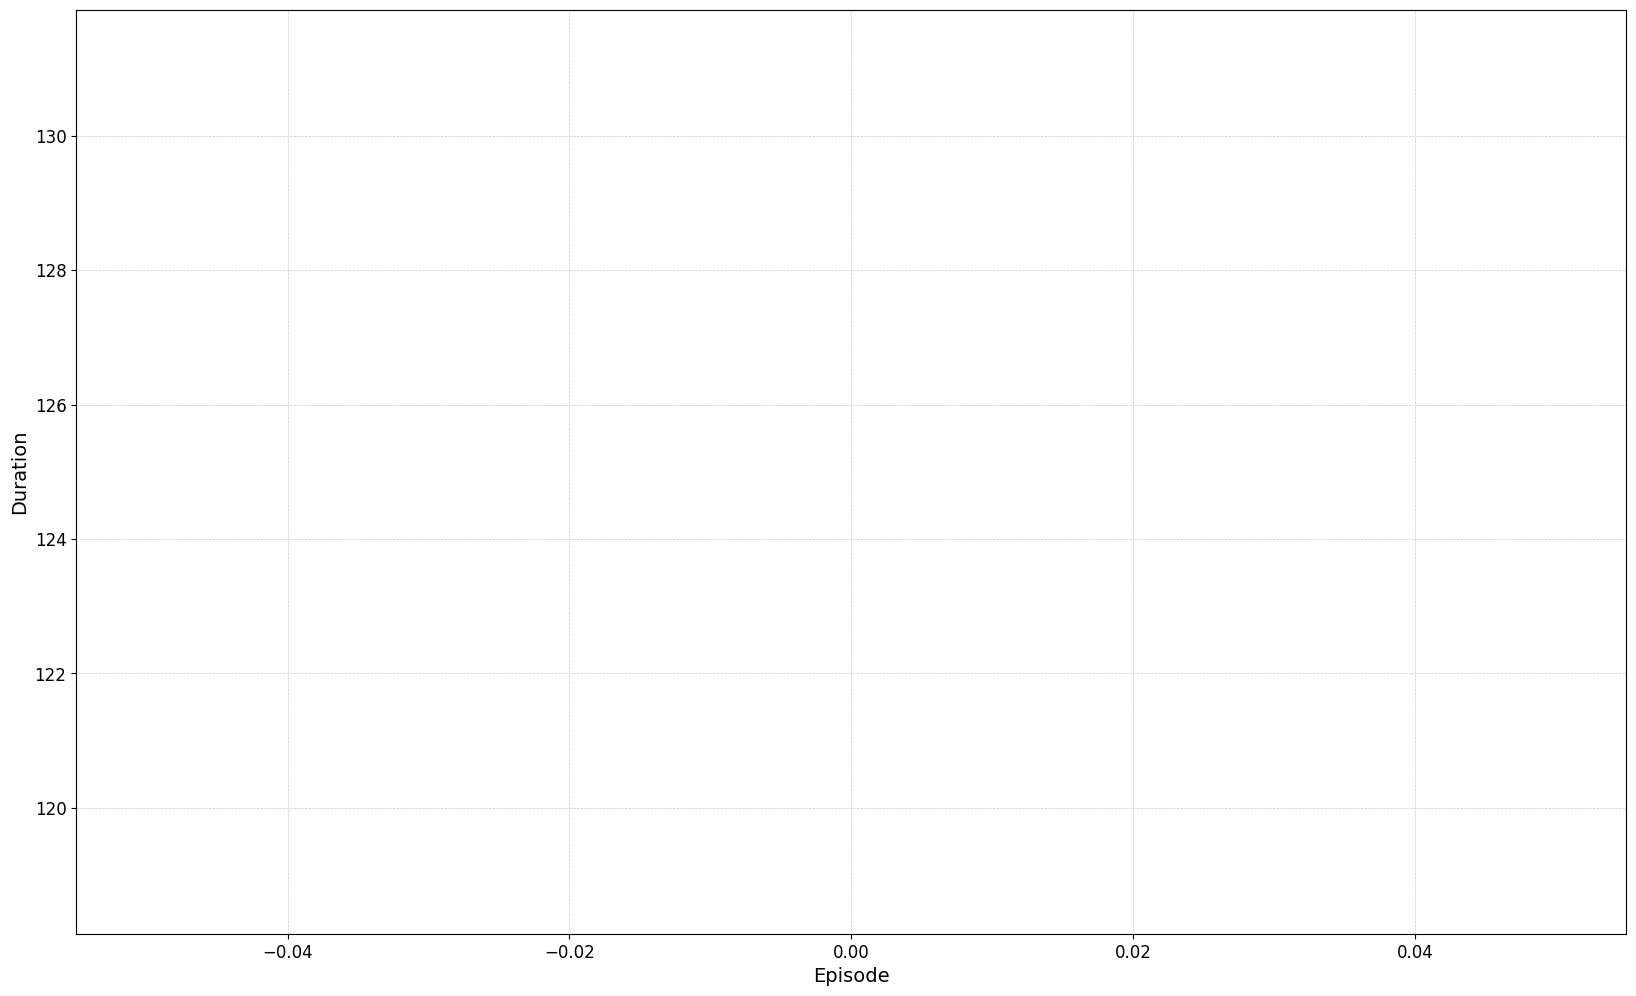

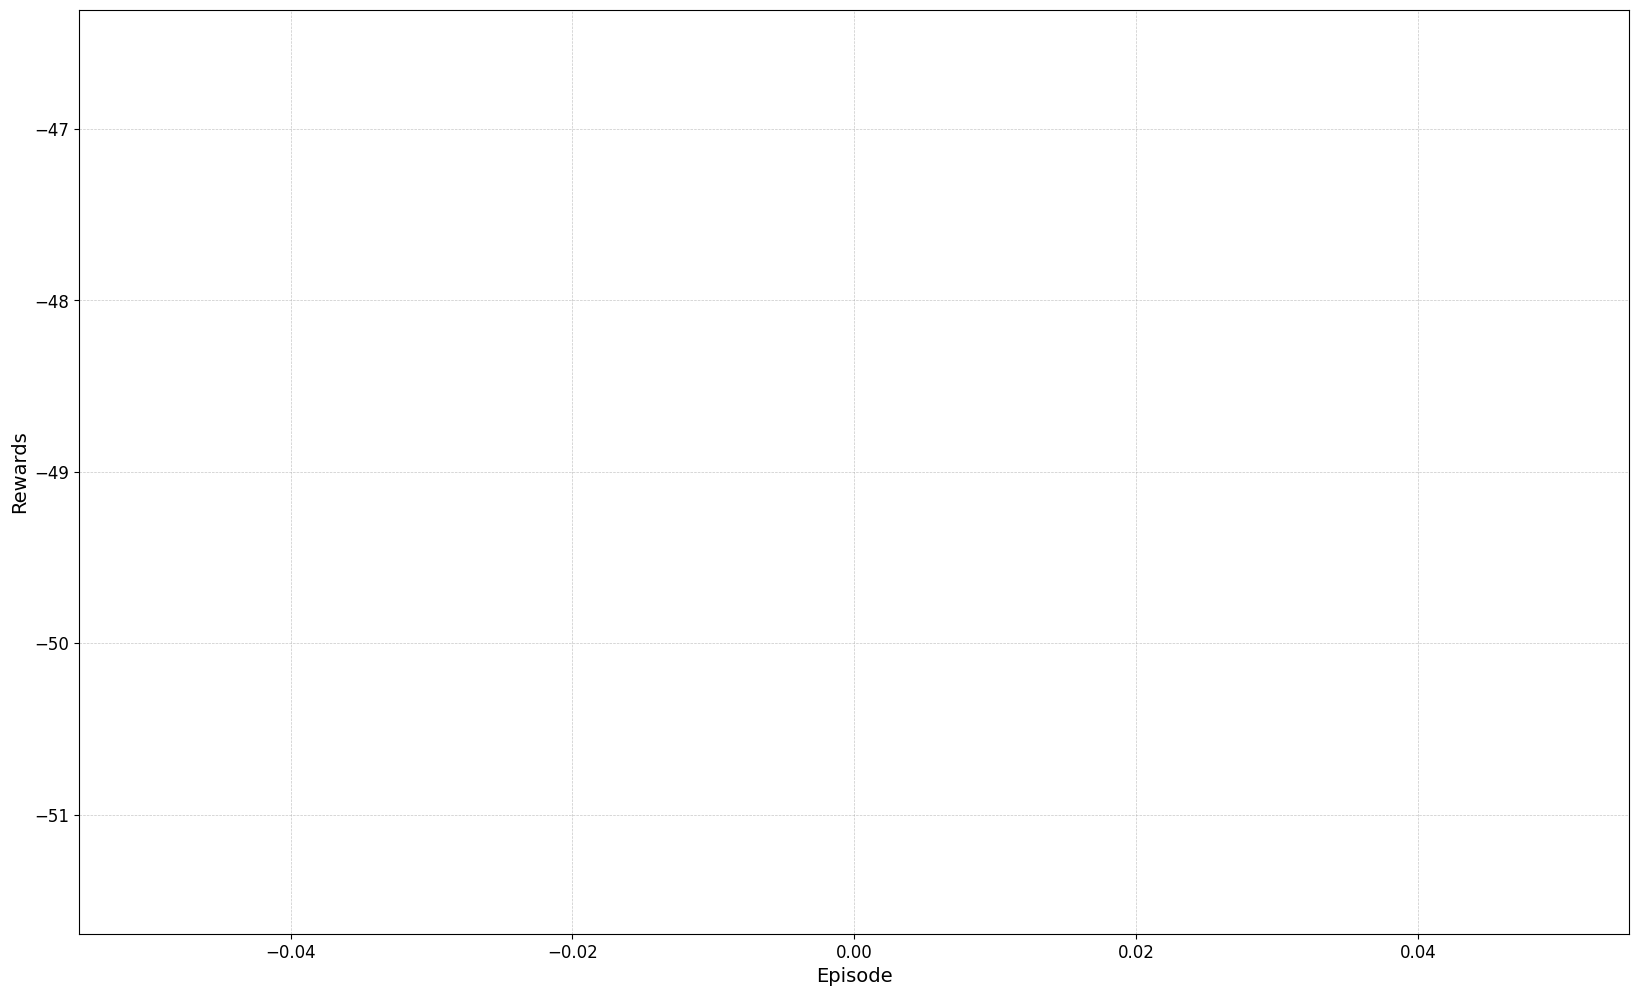

On episode 20, the average reward for the past 20 episodes is -49.0
The average duration of episode in the past 20 is 125.0


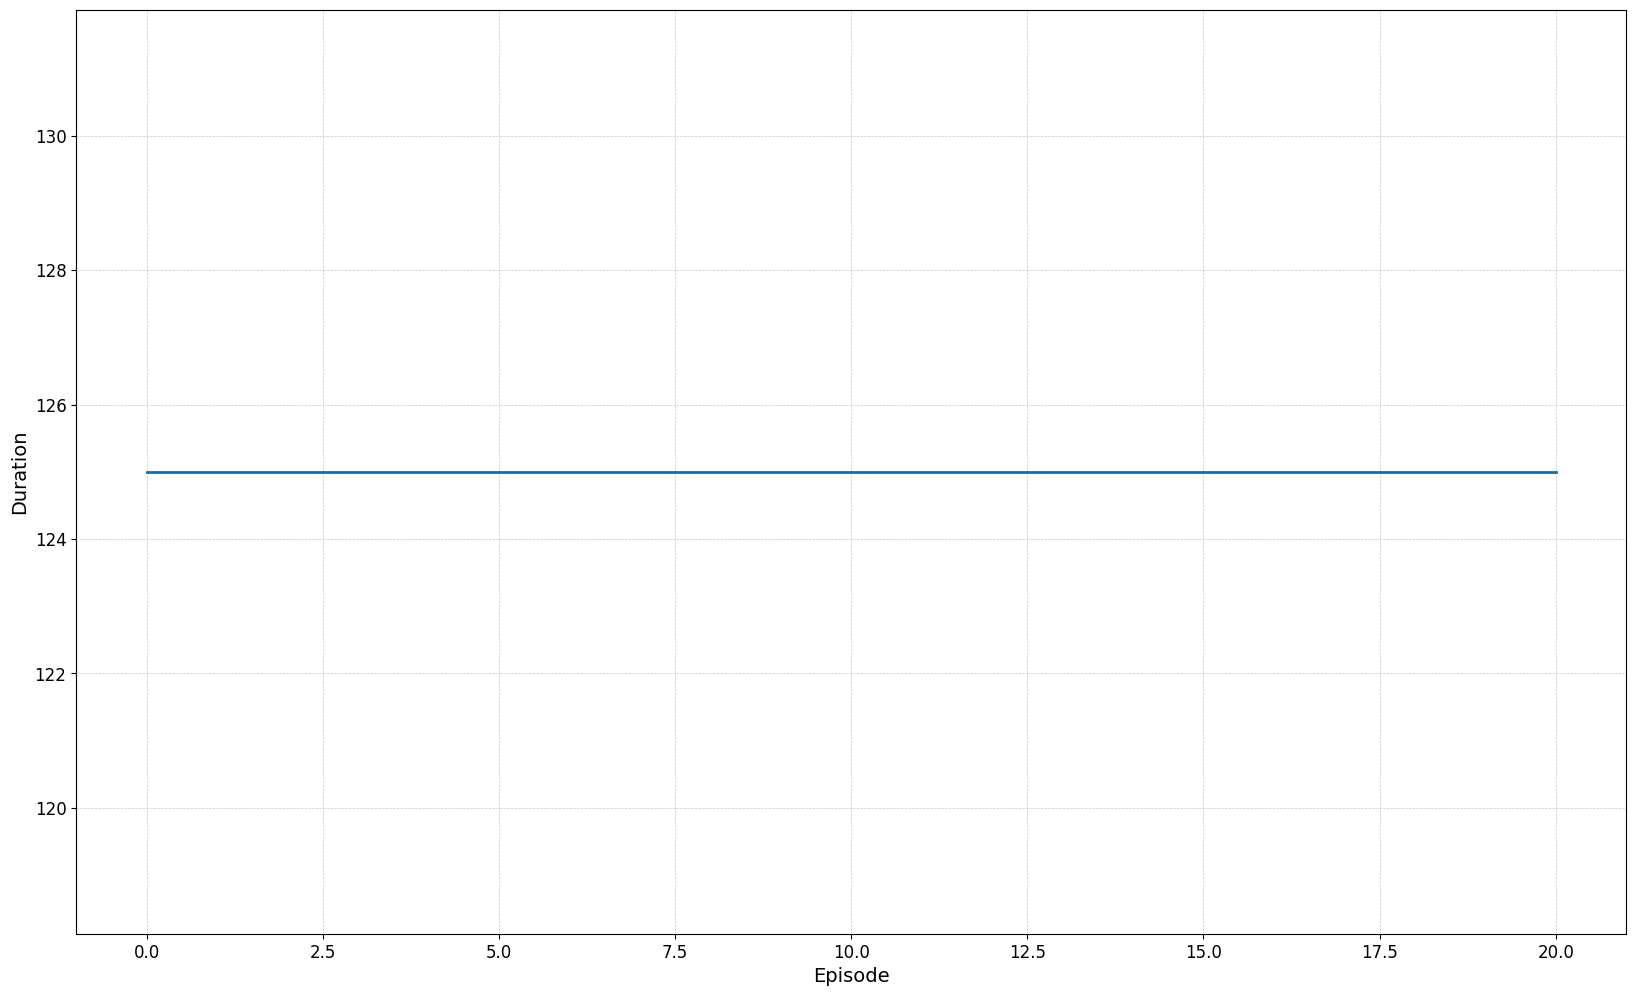

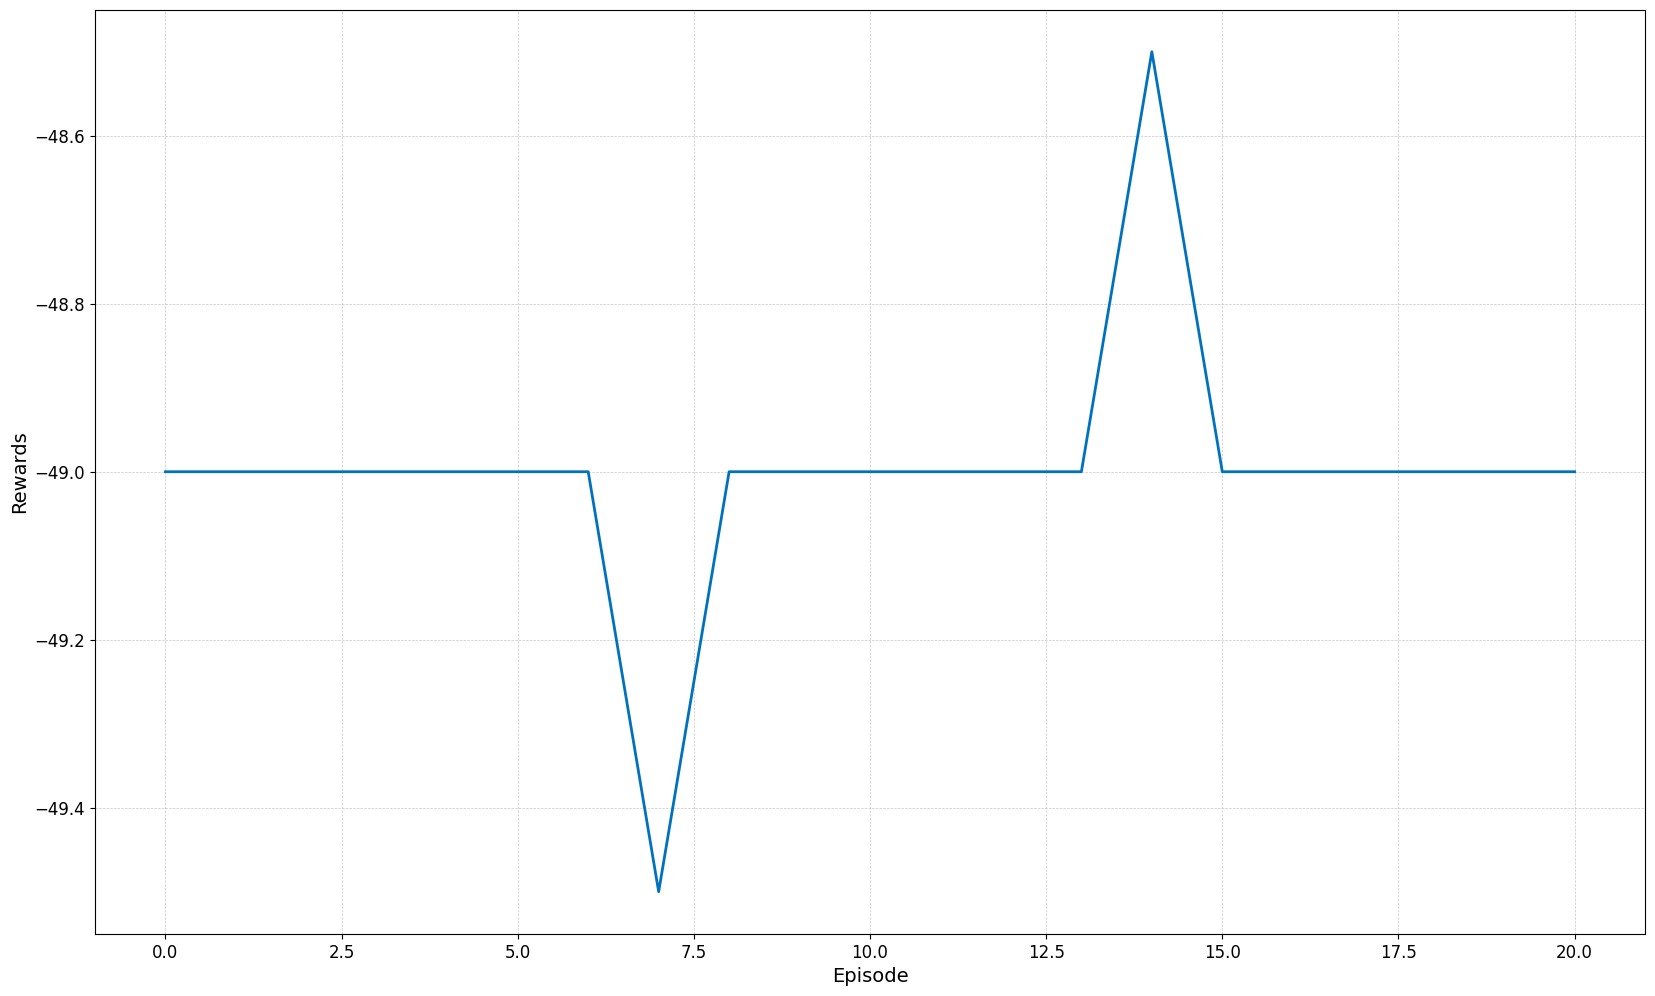

On episode 40, the average reward for the past 20 episodes is -48.75
The average duration of episode in the past 20 is 125.0


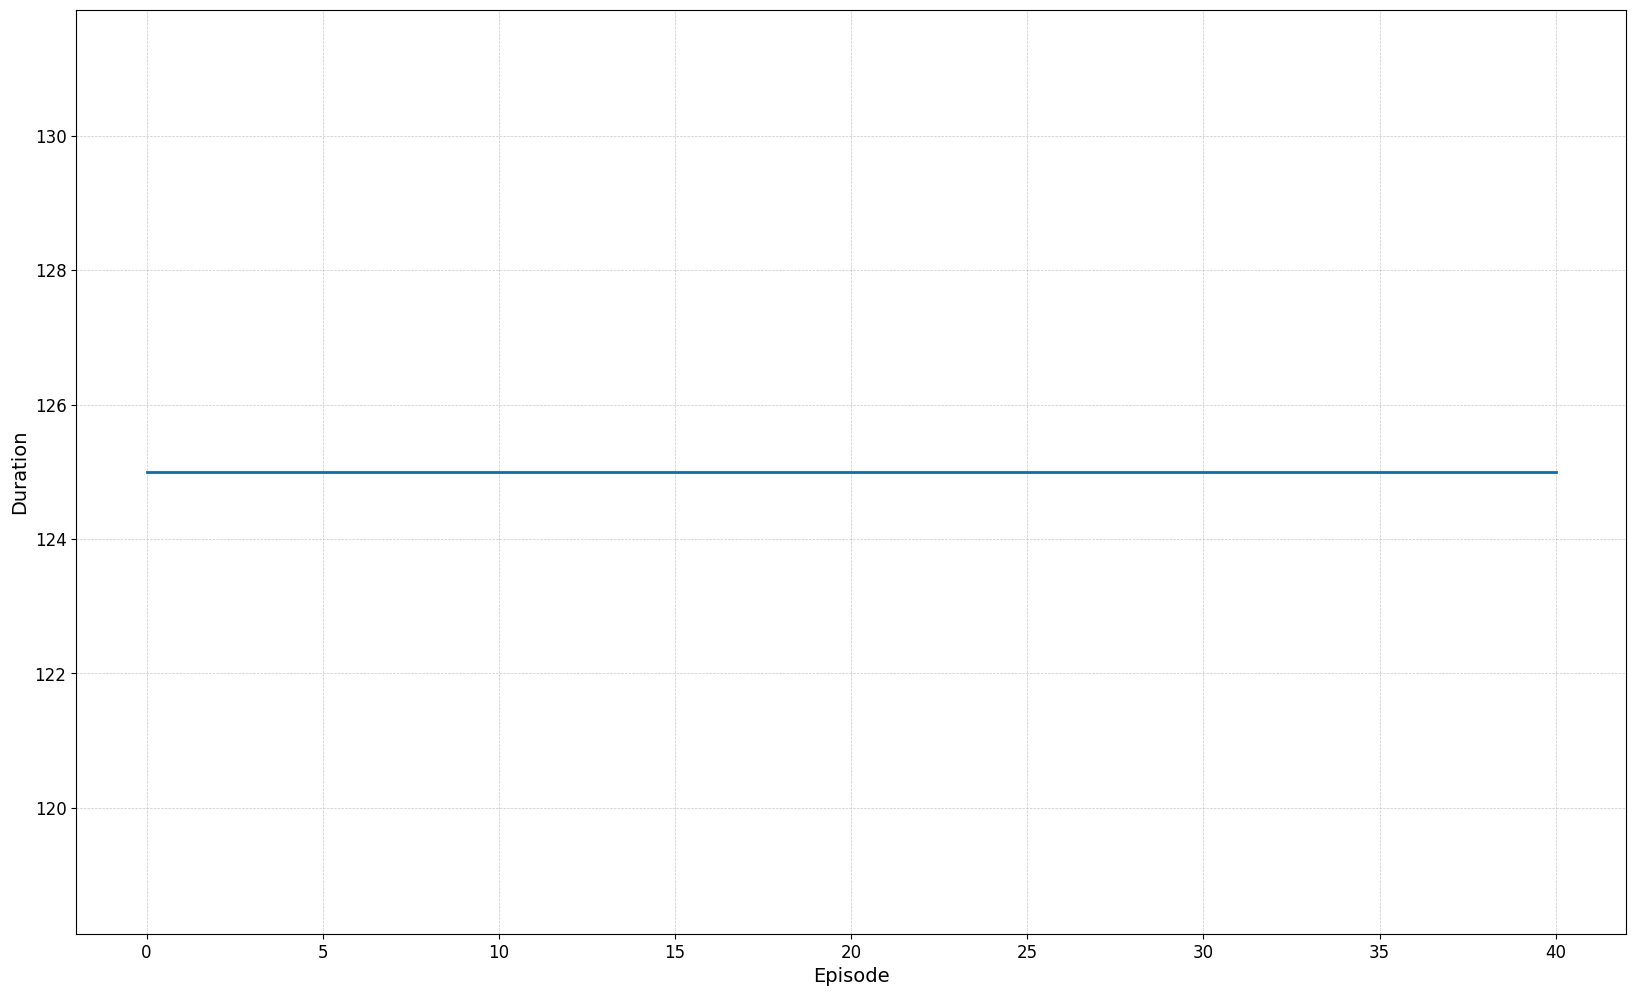

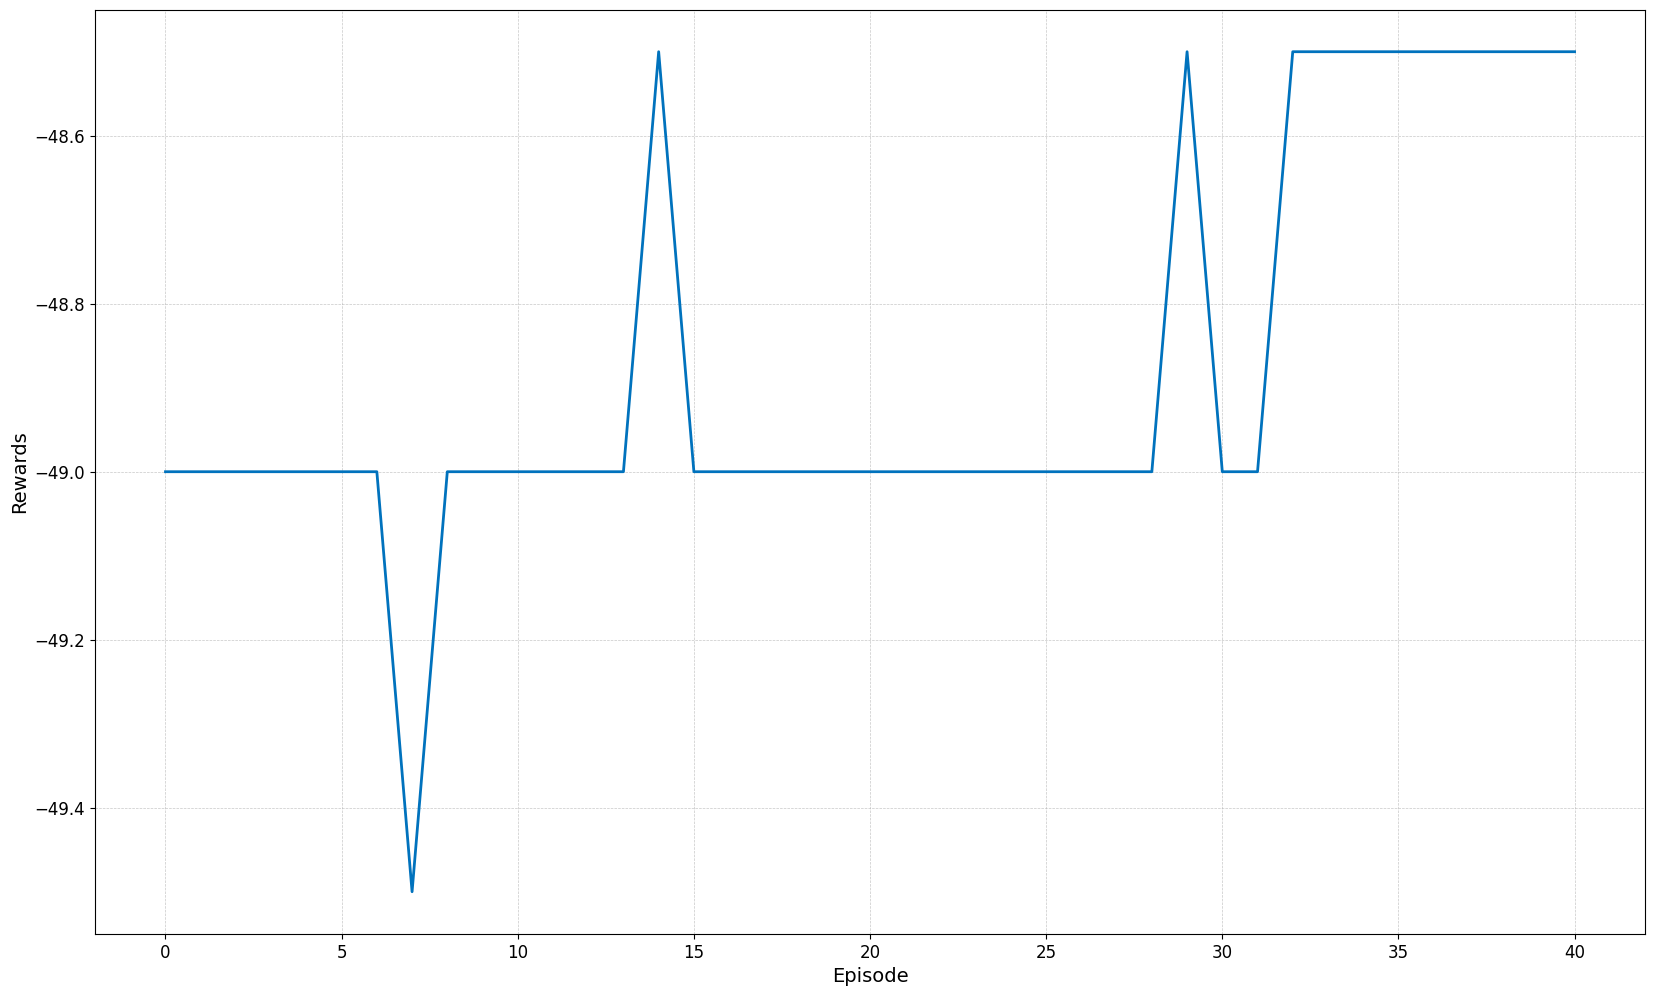

On episode 60, the average reward for the past 20 episodes is -48.53
The average duration of episode in the past 20 is 125.0


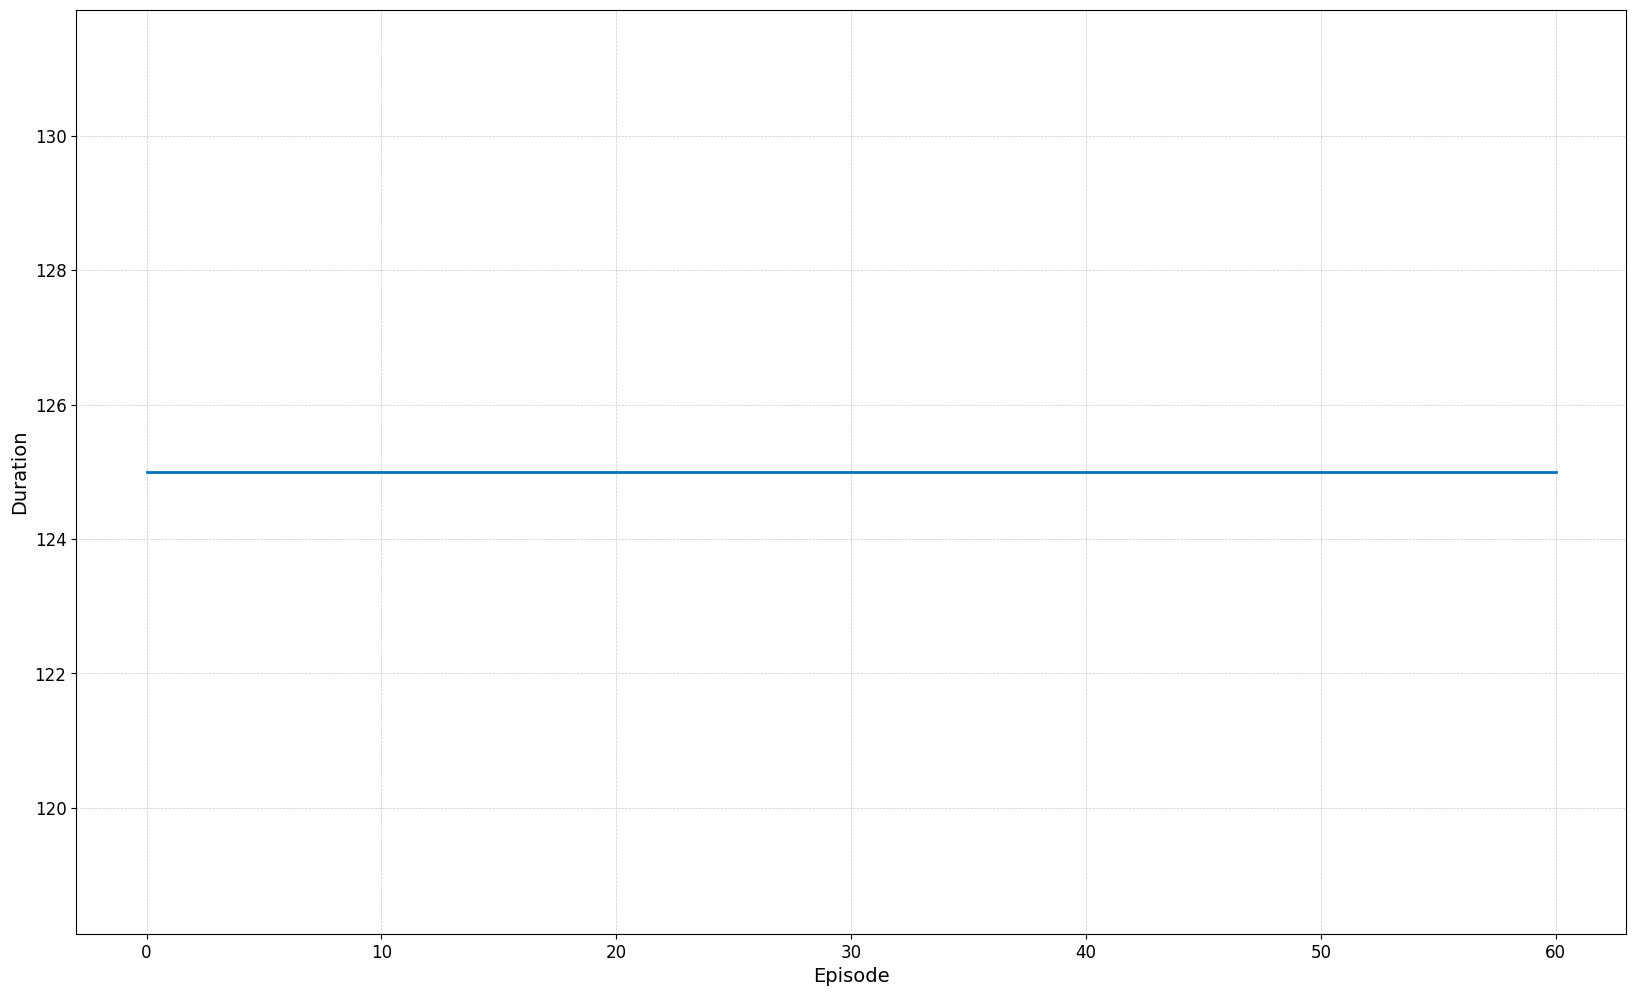

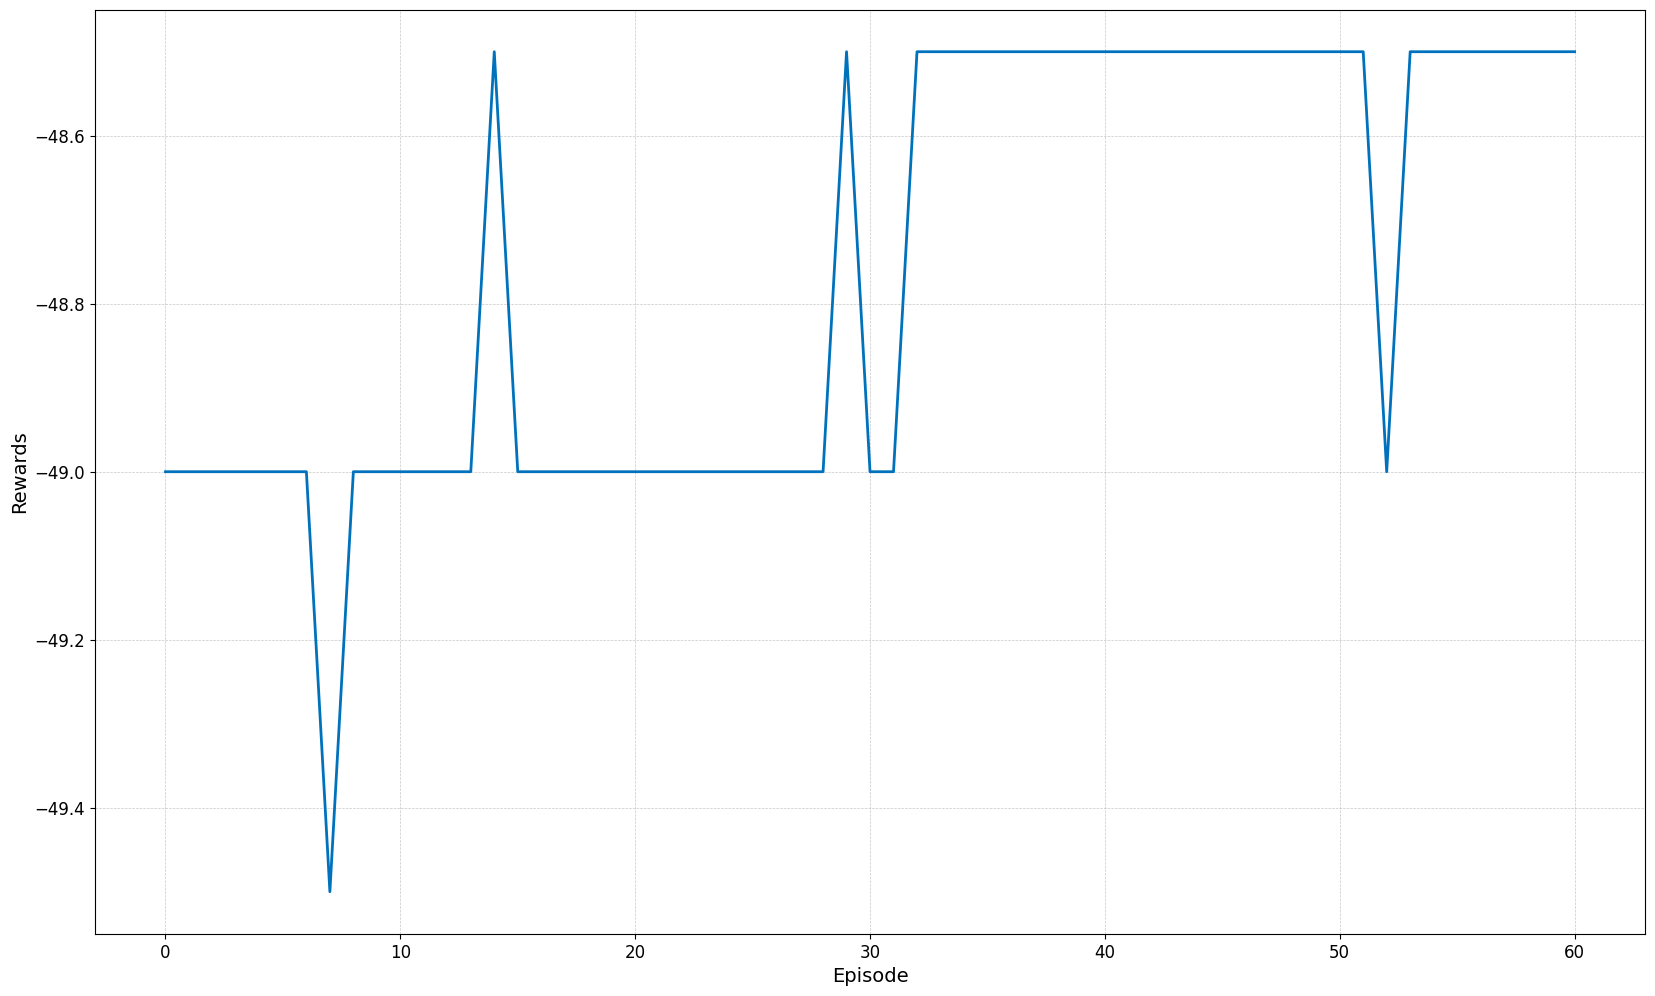

On episode 80, the average reward for the past 20 episodes is -46.35
The average duration of episode in the past 20 is 121.7


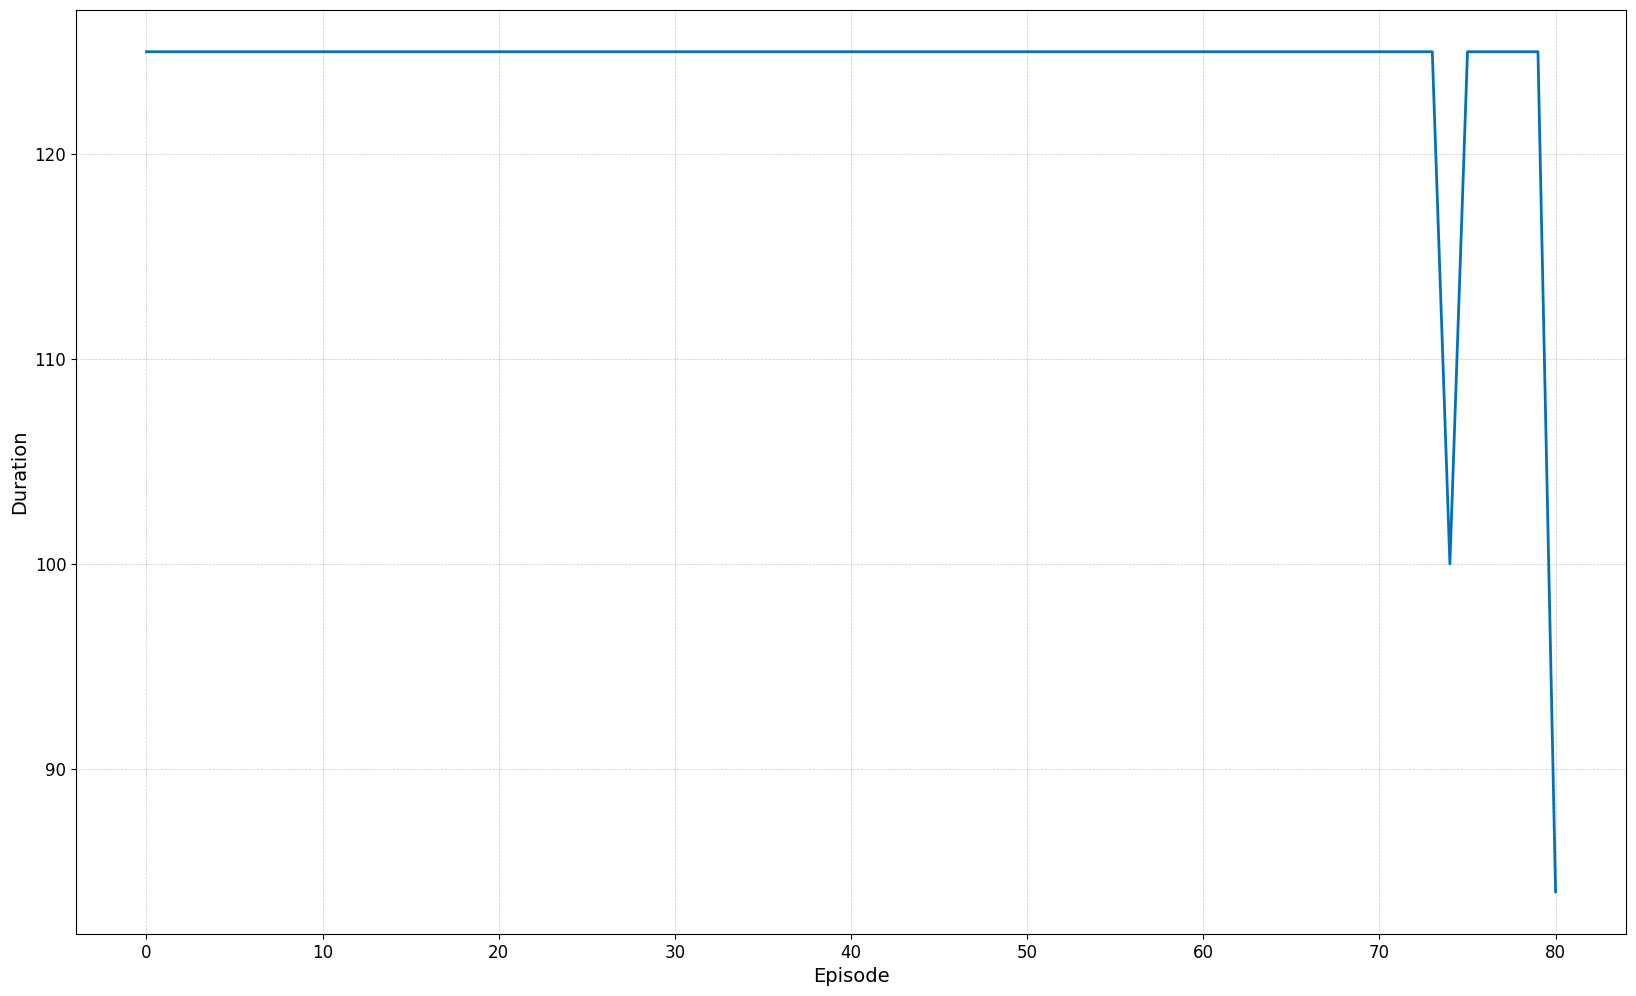

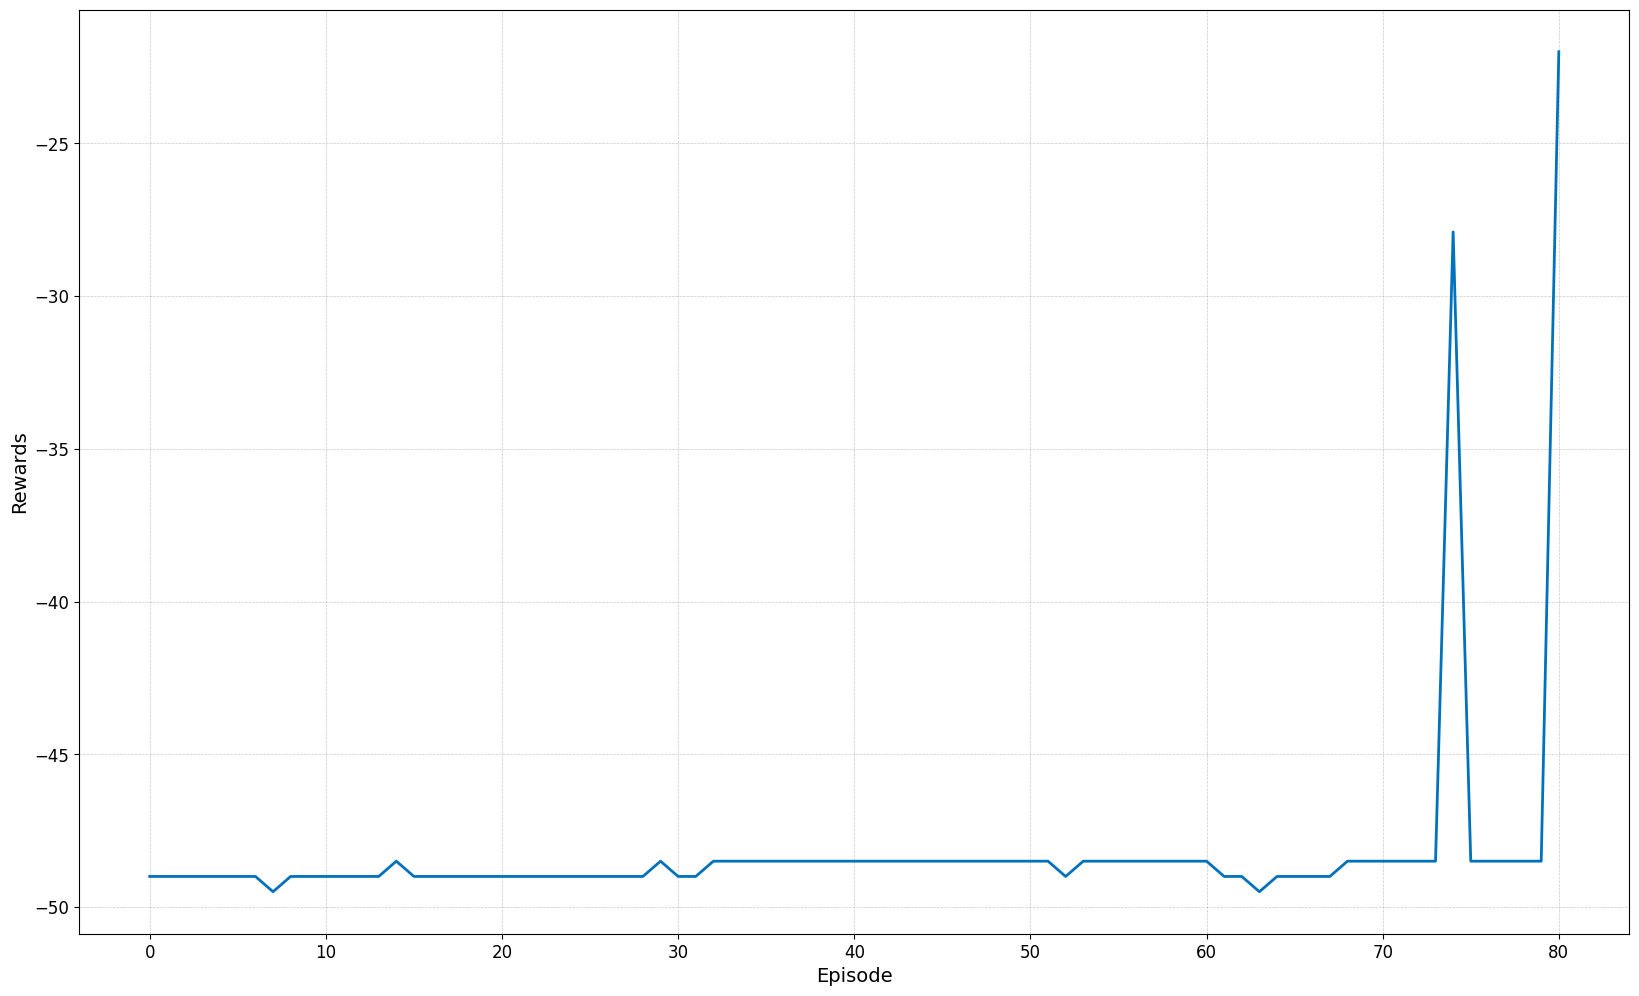

On episode 100, the average reward for the past 20 episodes is -35.23
The average duration of episode in the past 20 is 100.15


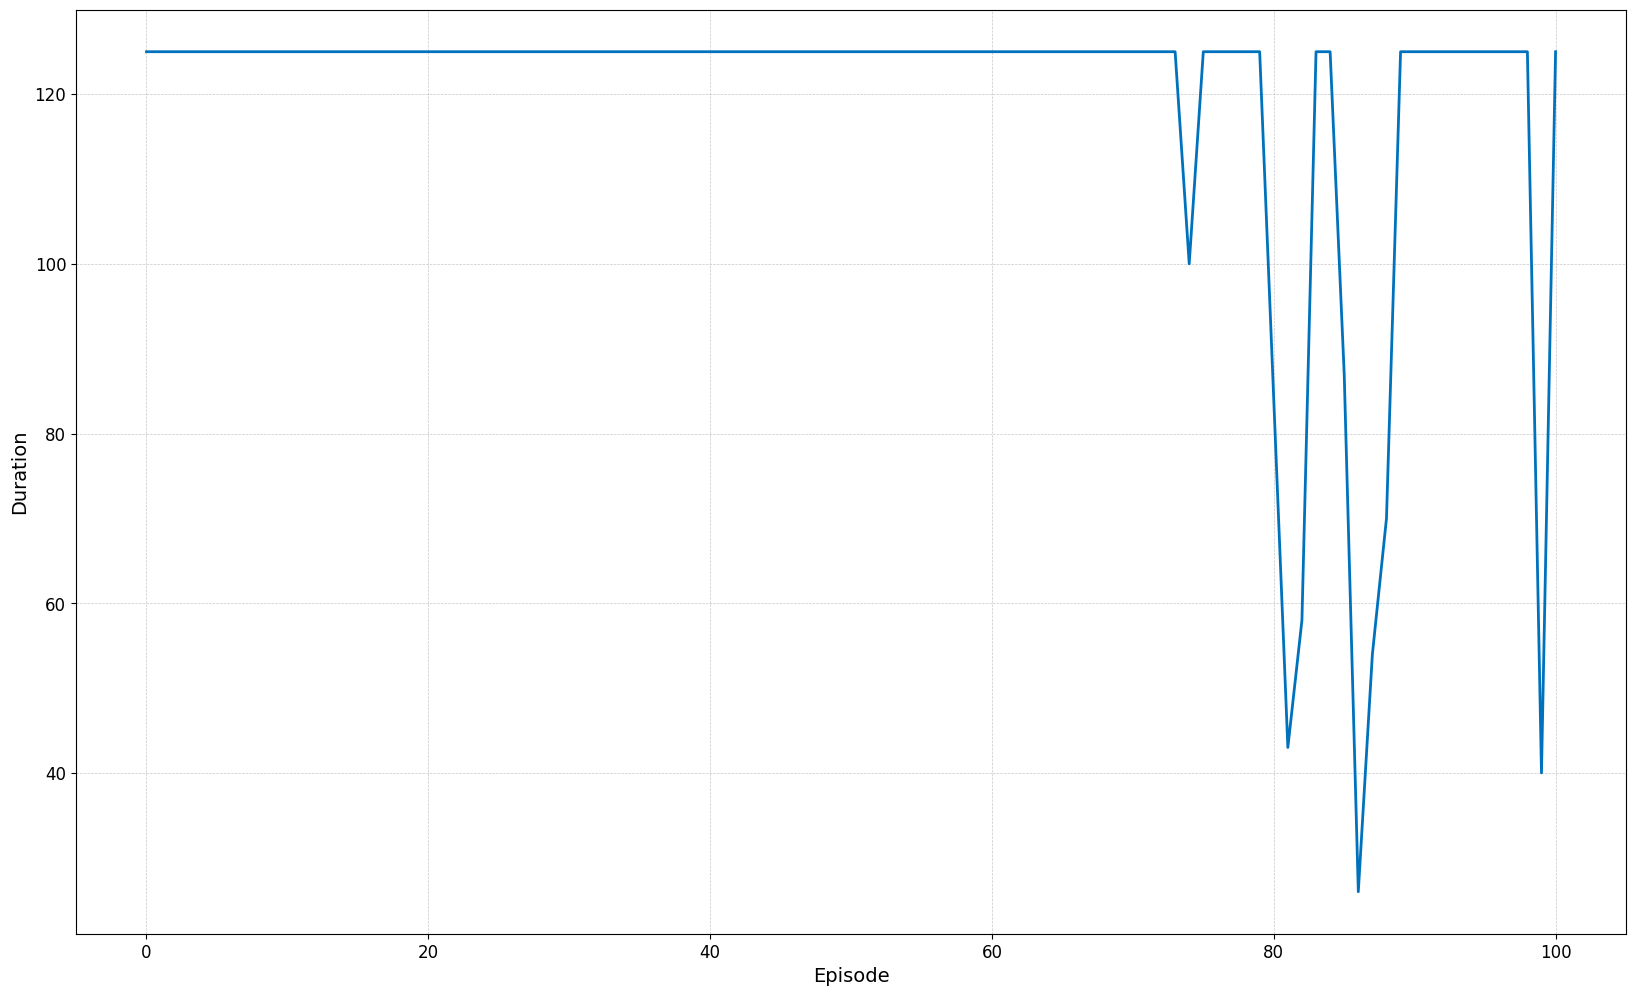

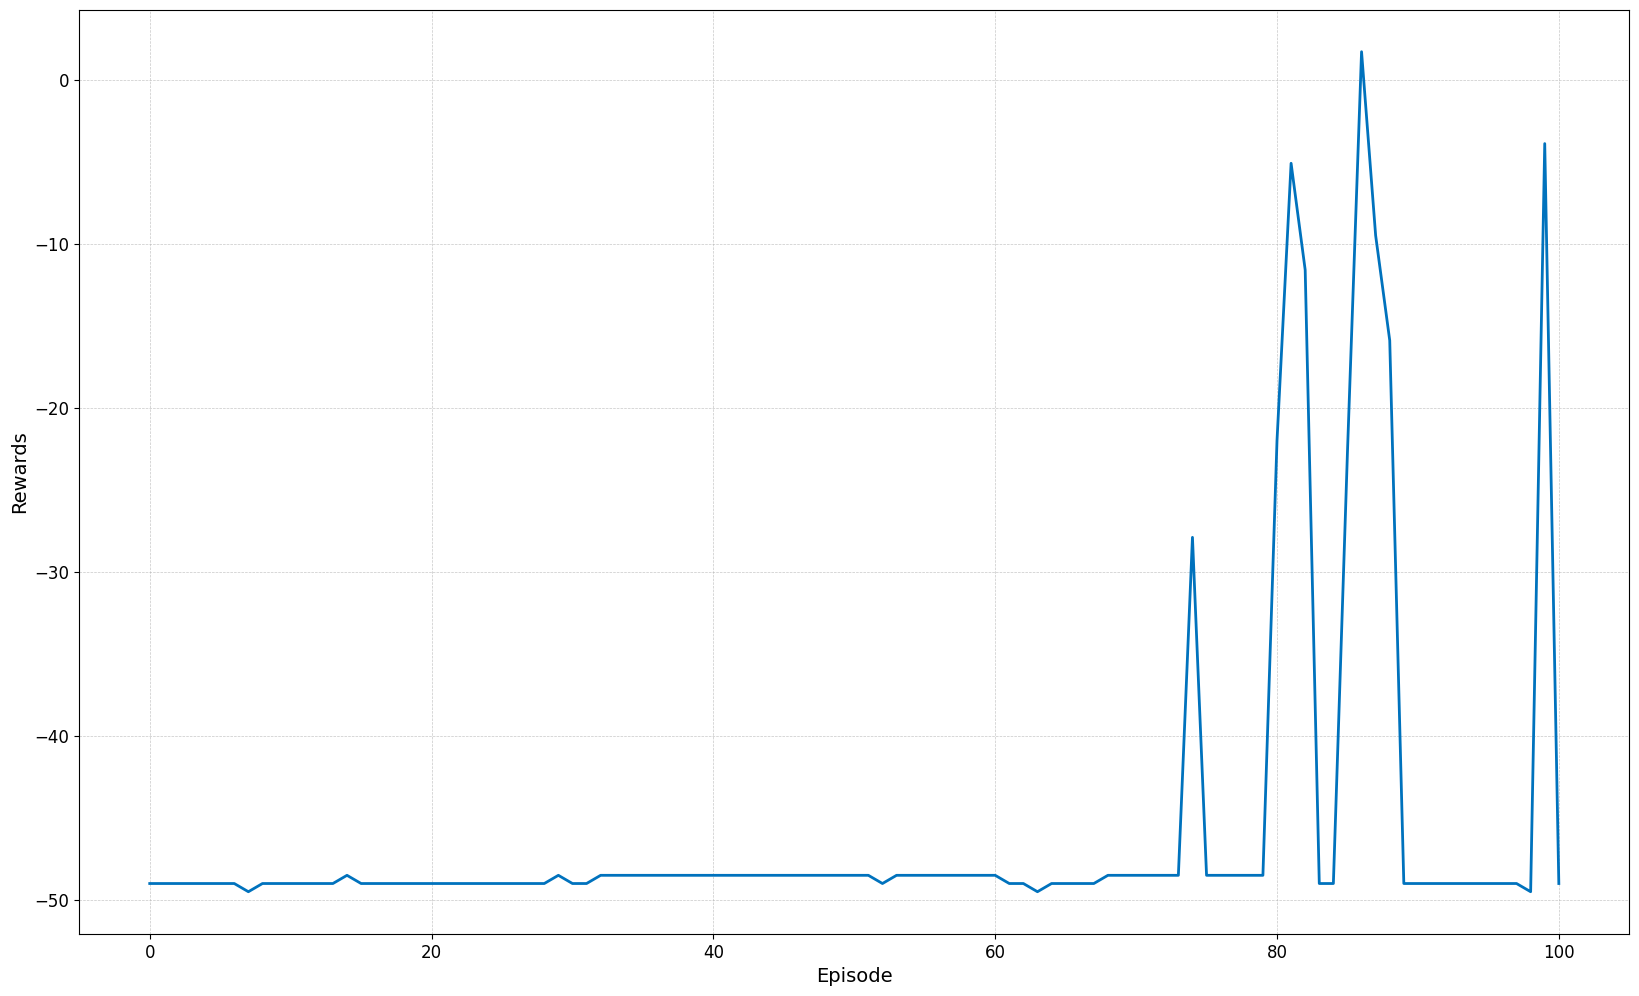

On episode 120, the average reward for the past 20 episodes is 6.02
The average duration of episode in the past 20 is 15.2


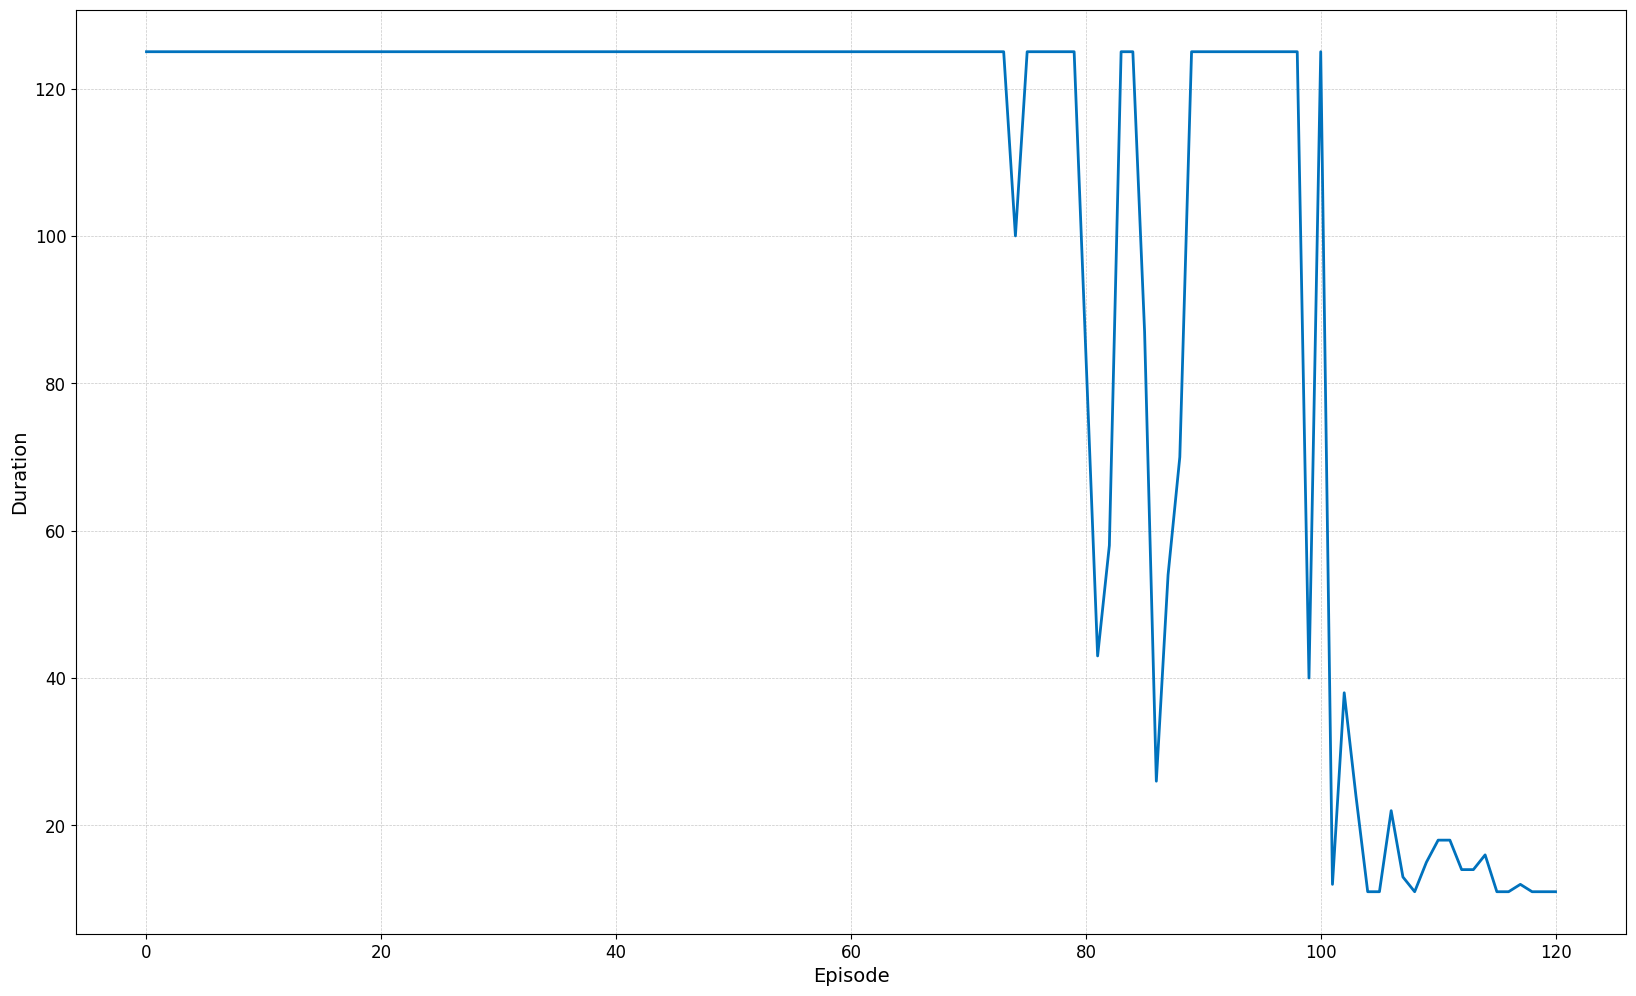

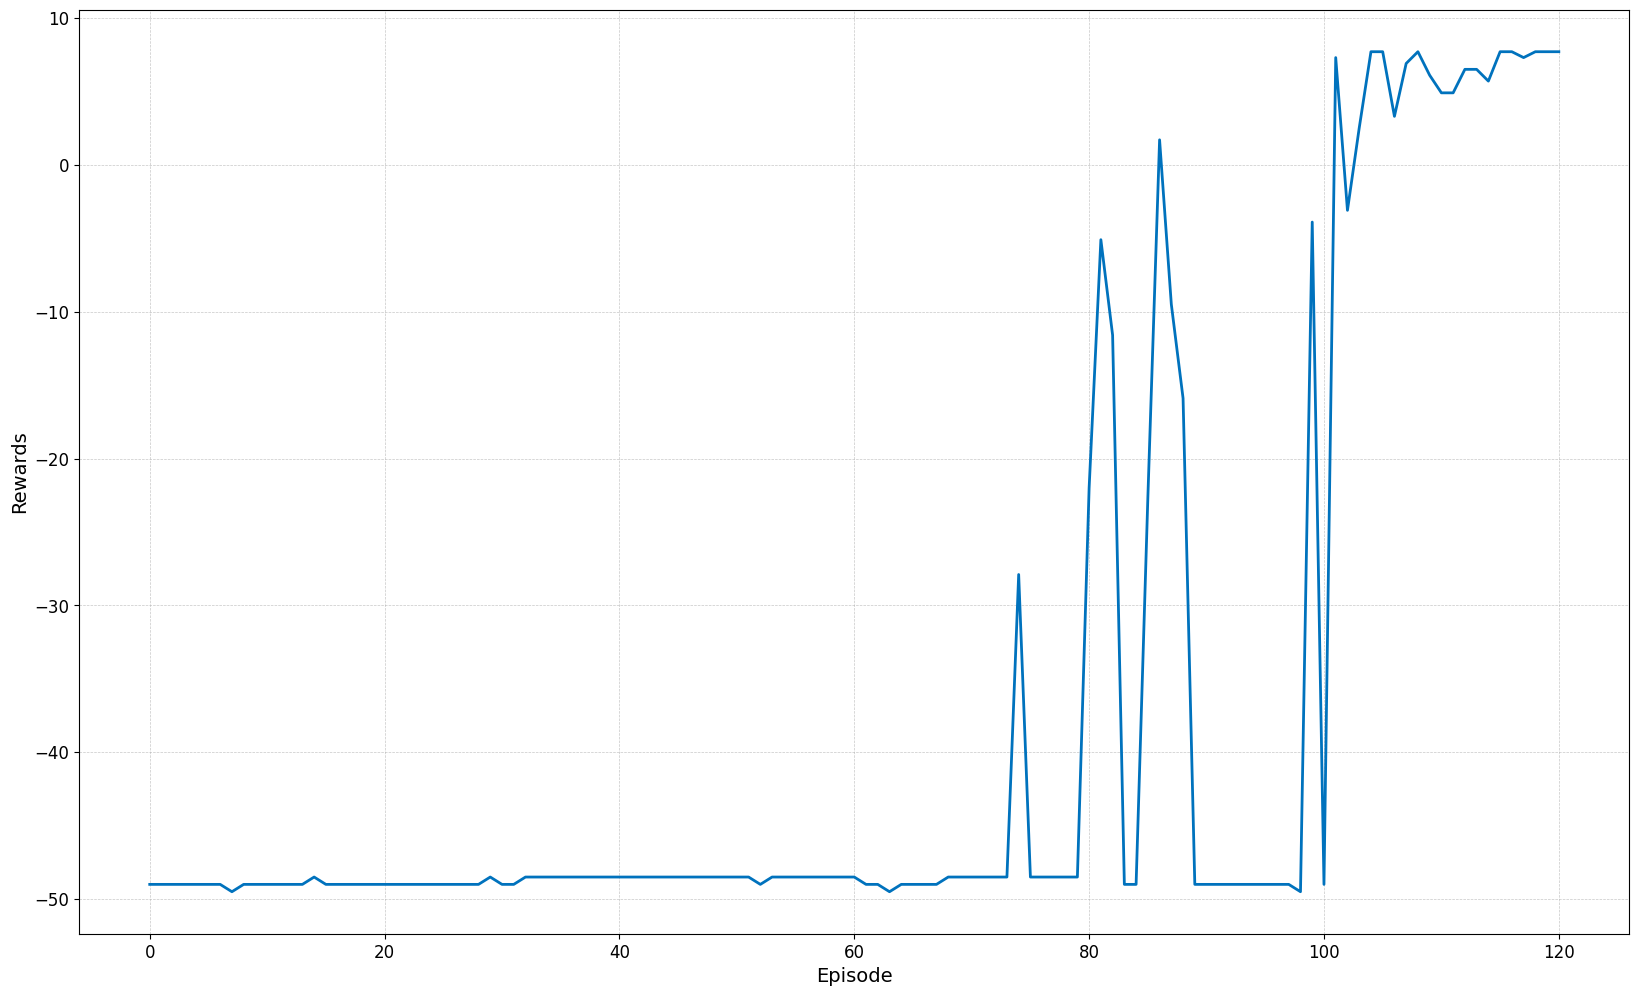

On episode 140, the average reward for the past 20 episodes is 2.58
The average duration of episode in the past 20 is 22.35


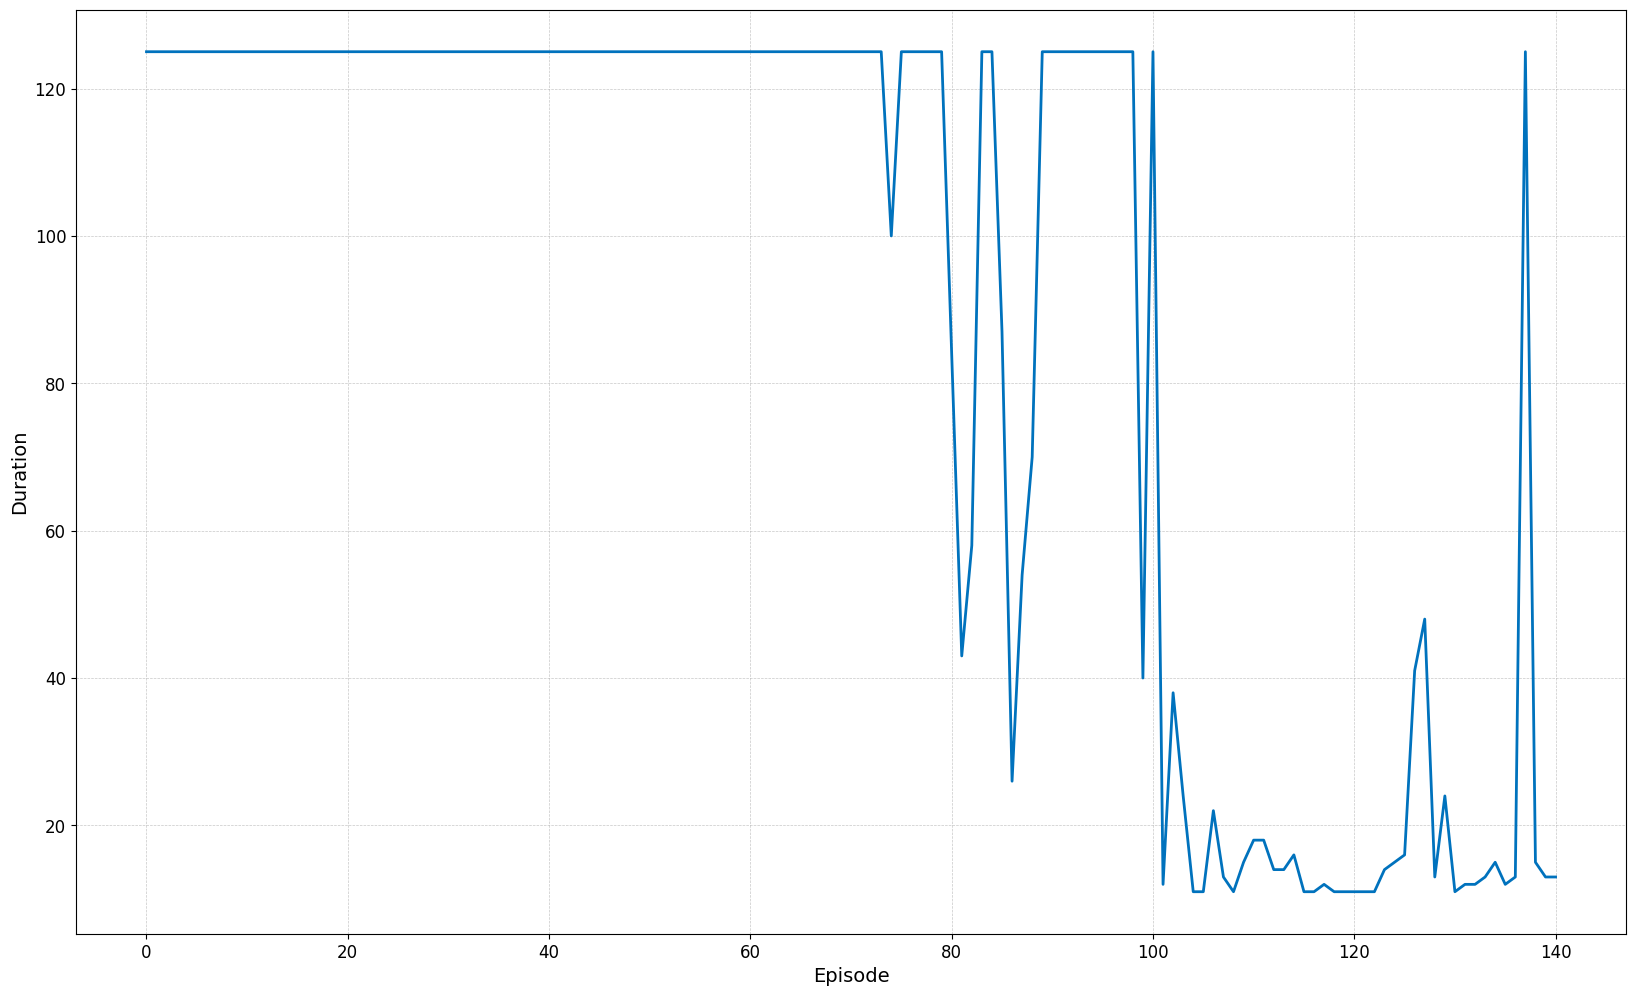

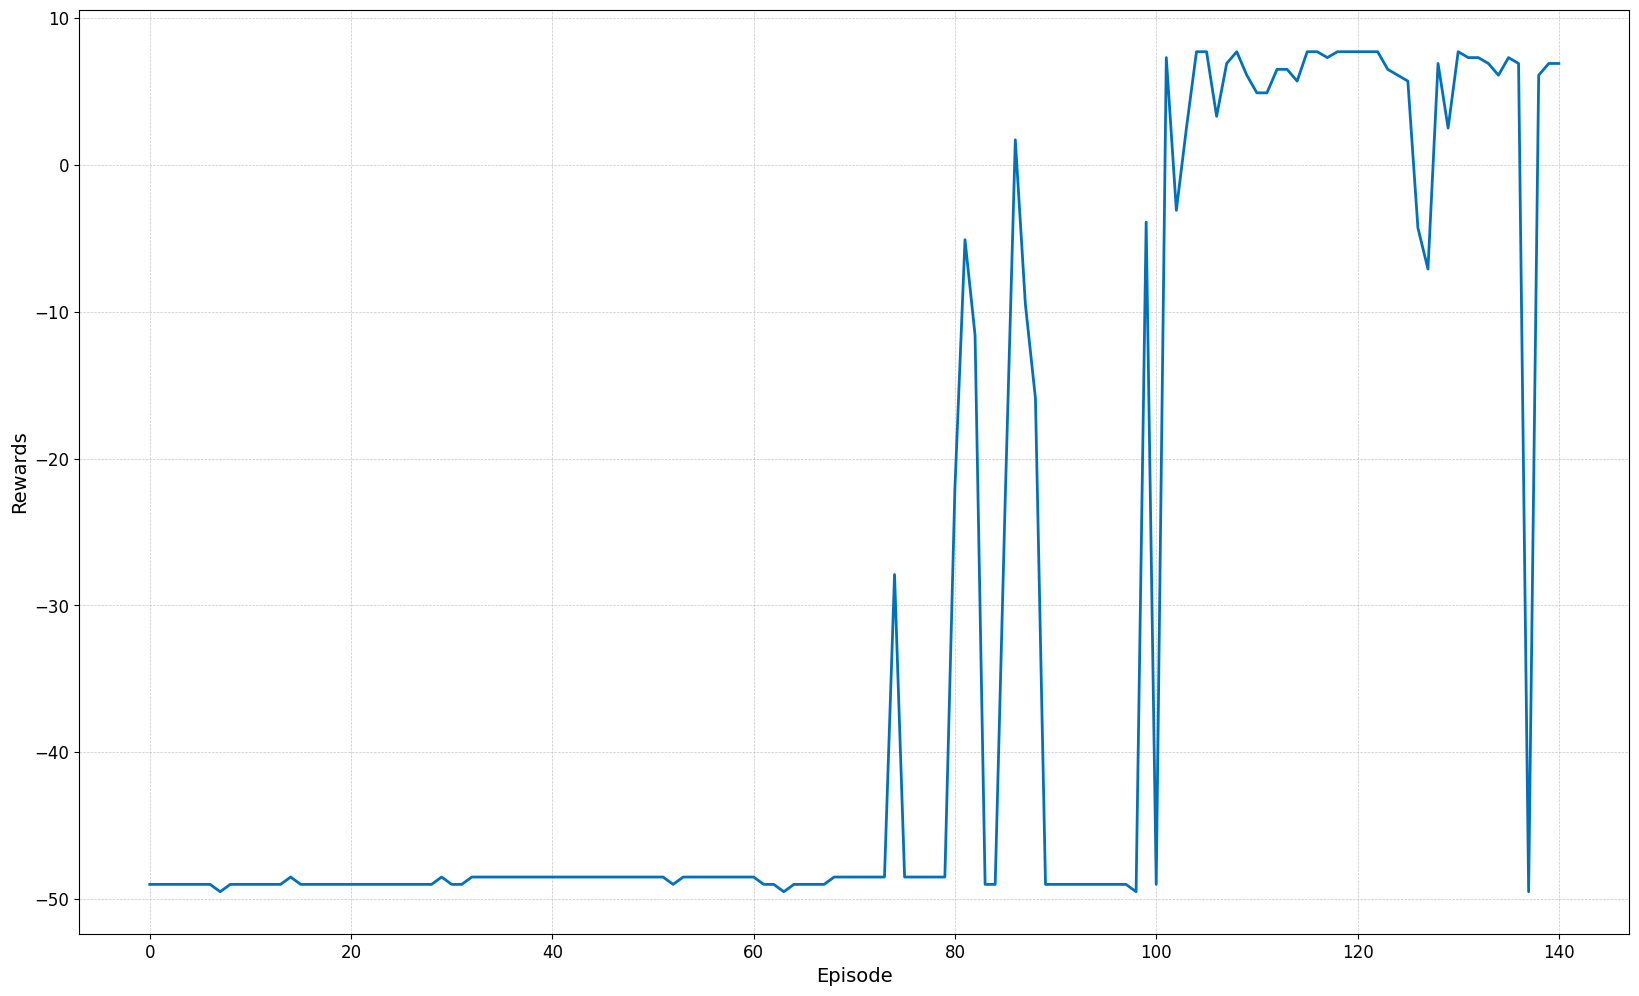

On episode 160, the average reward for the past 20 episodes is 1.2
The average duration of episode in the past 20 is 24.4


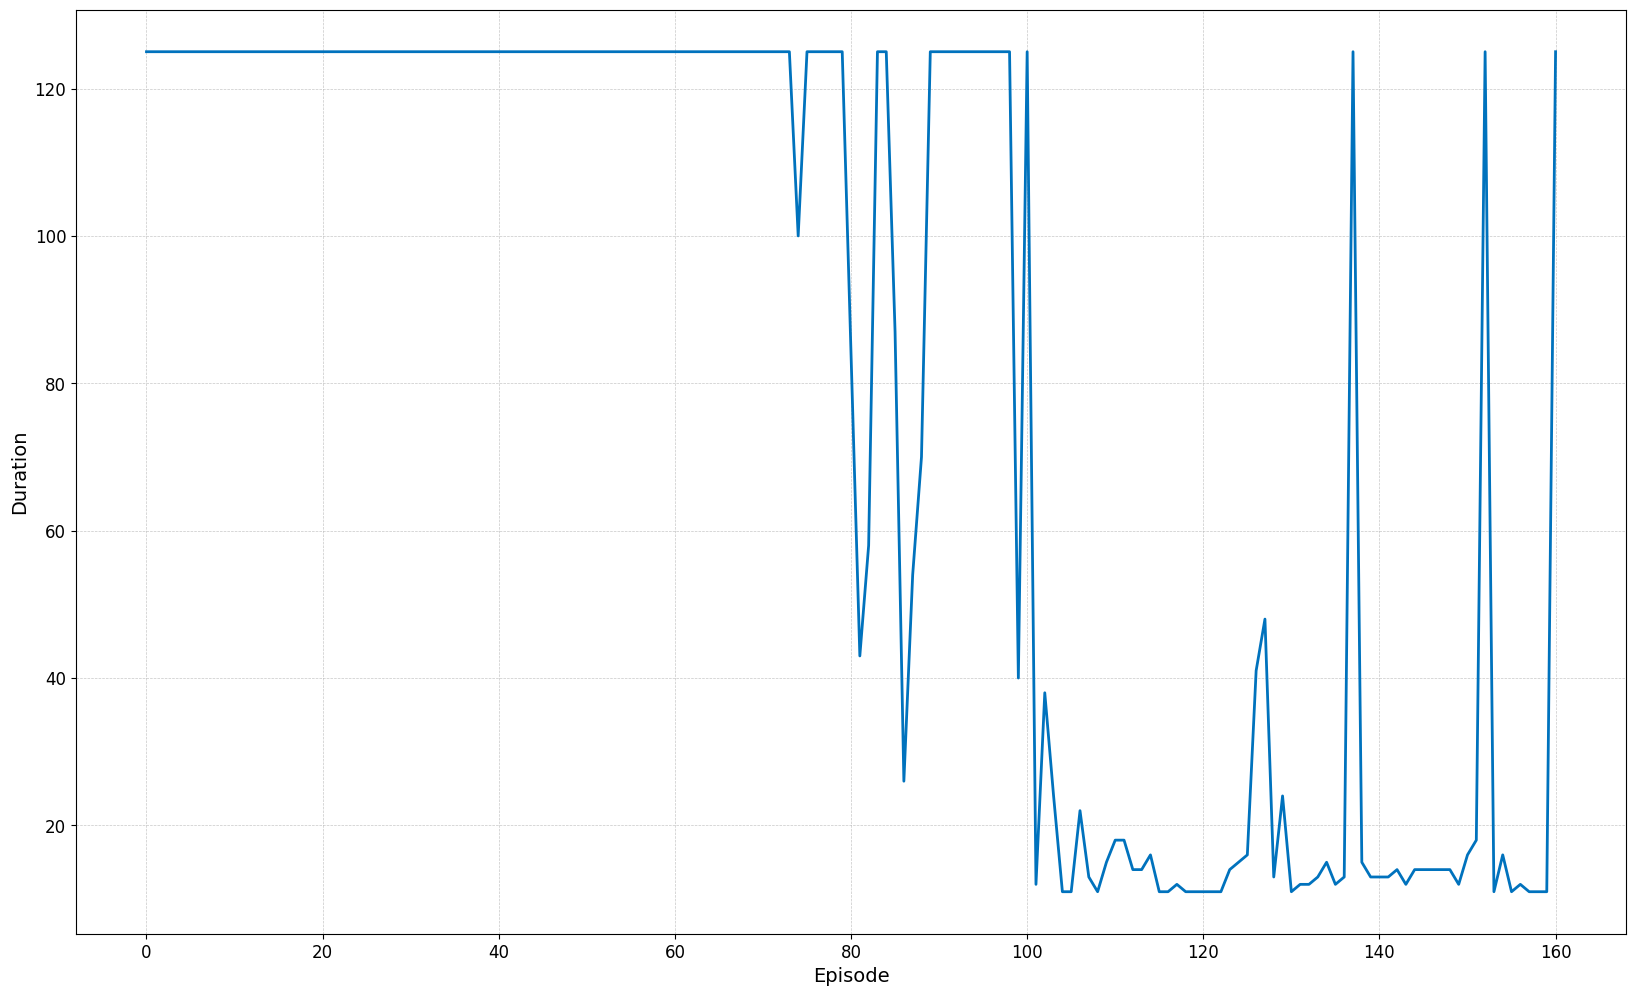

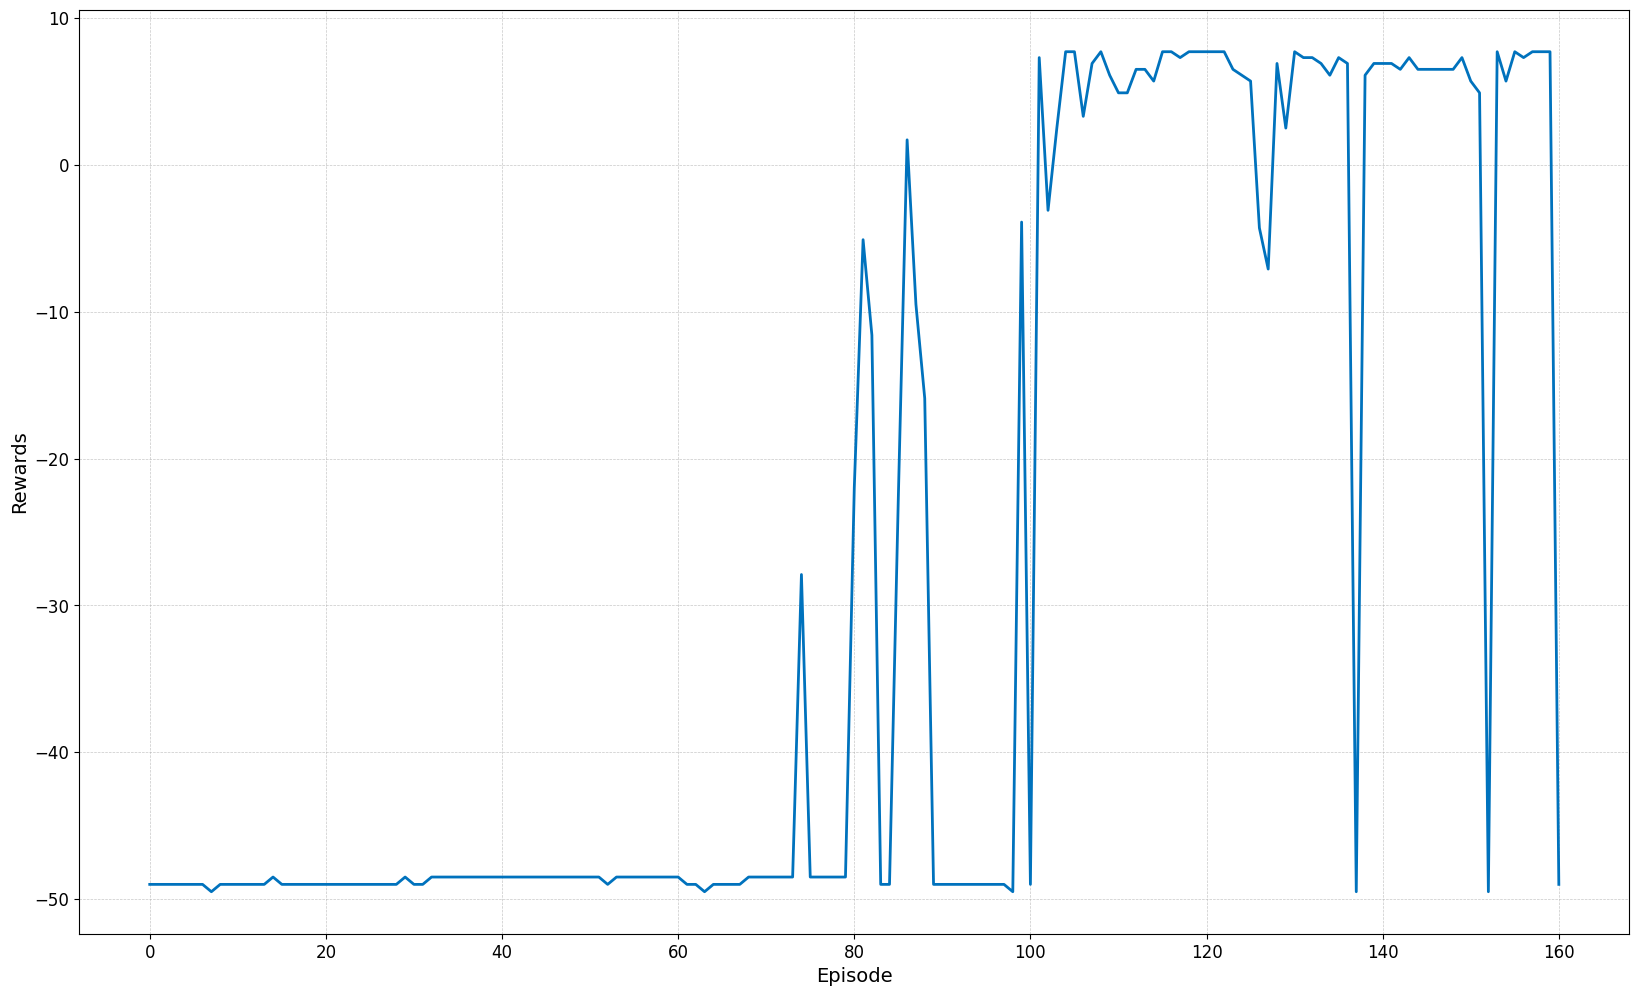

On episode 180, the average reward for the past 20 episodes is 7.32
The average duration of episode in the past 20 is 11.95


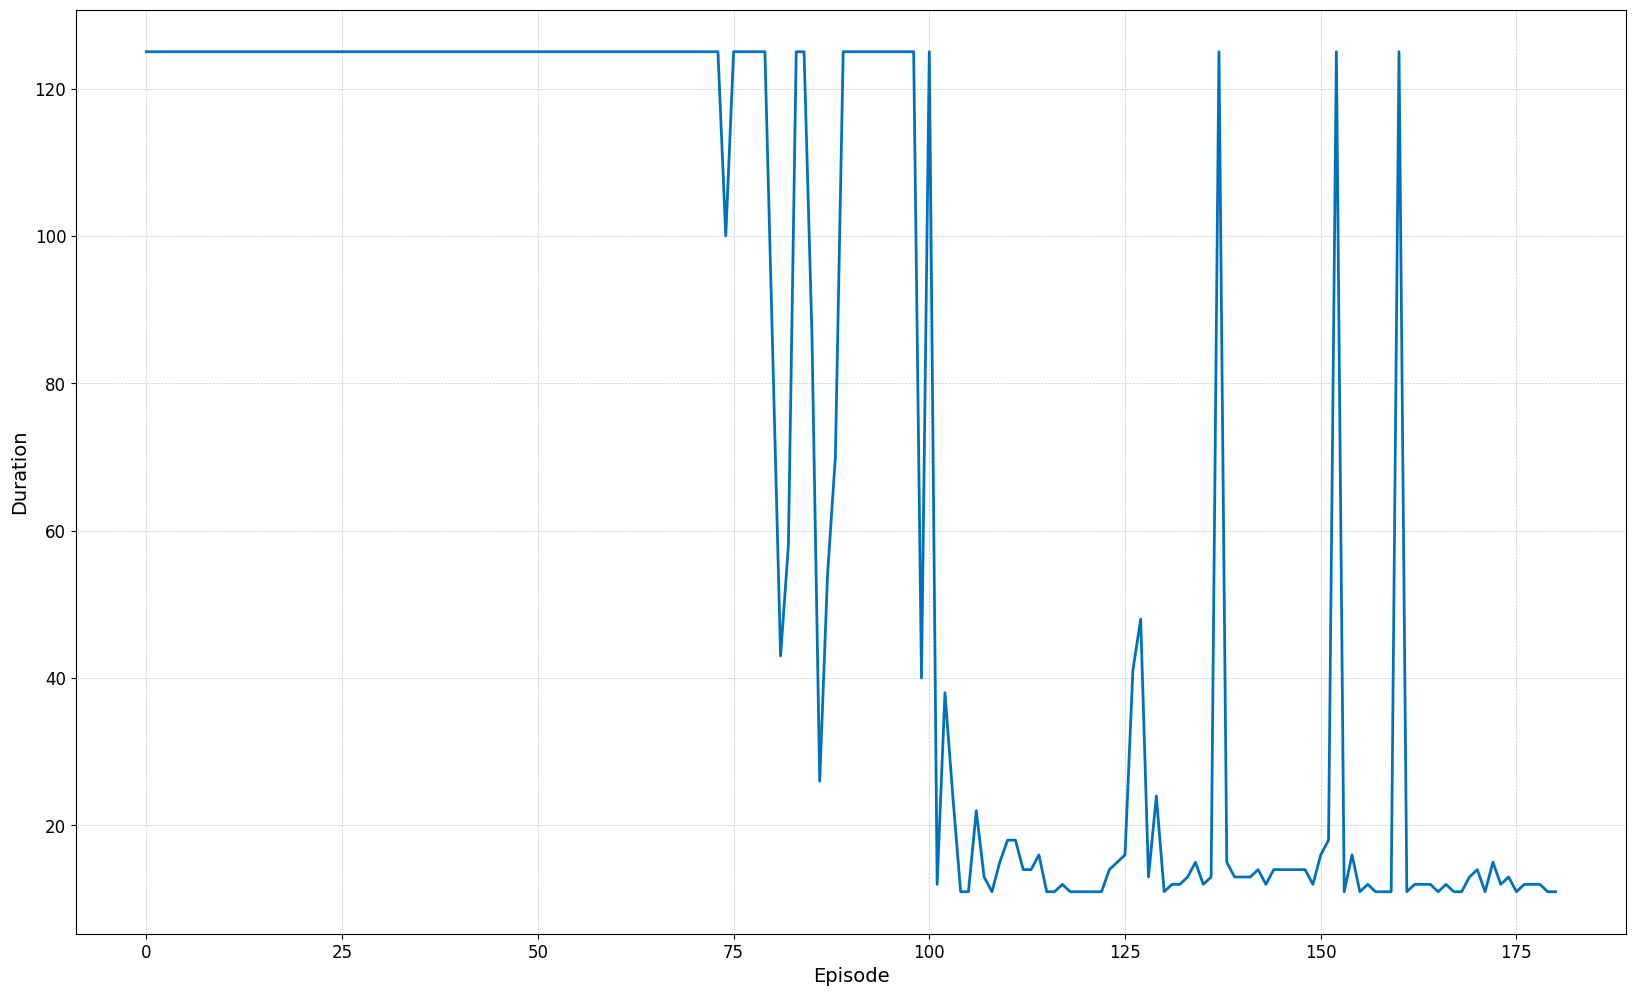

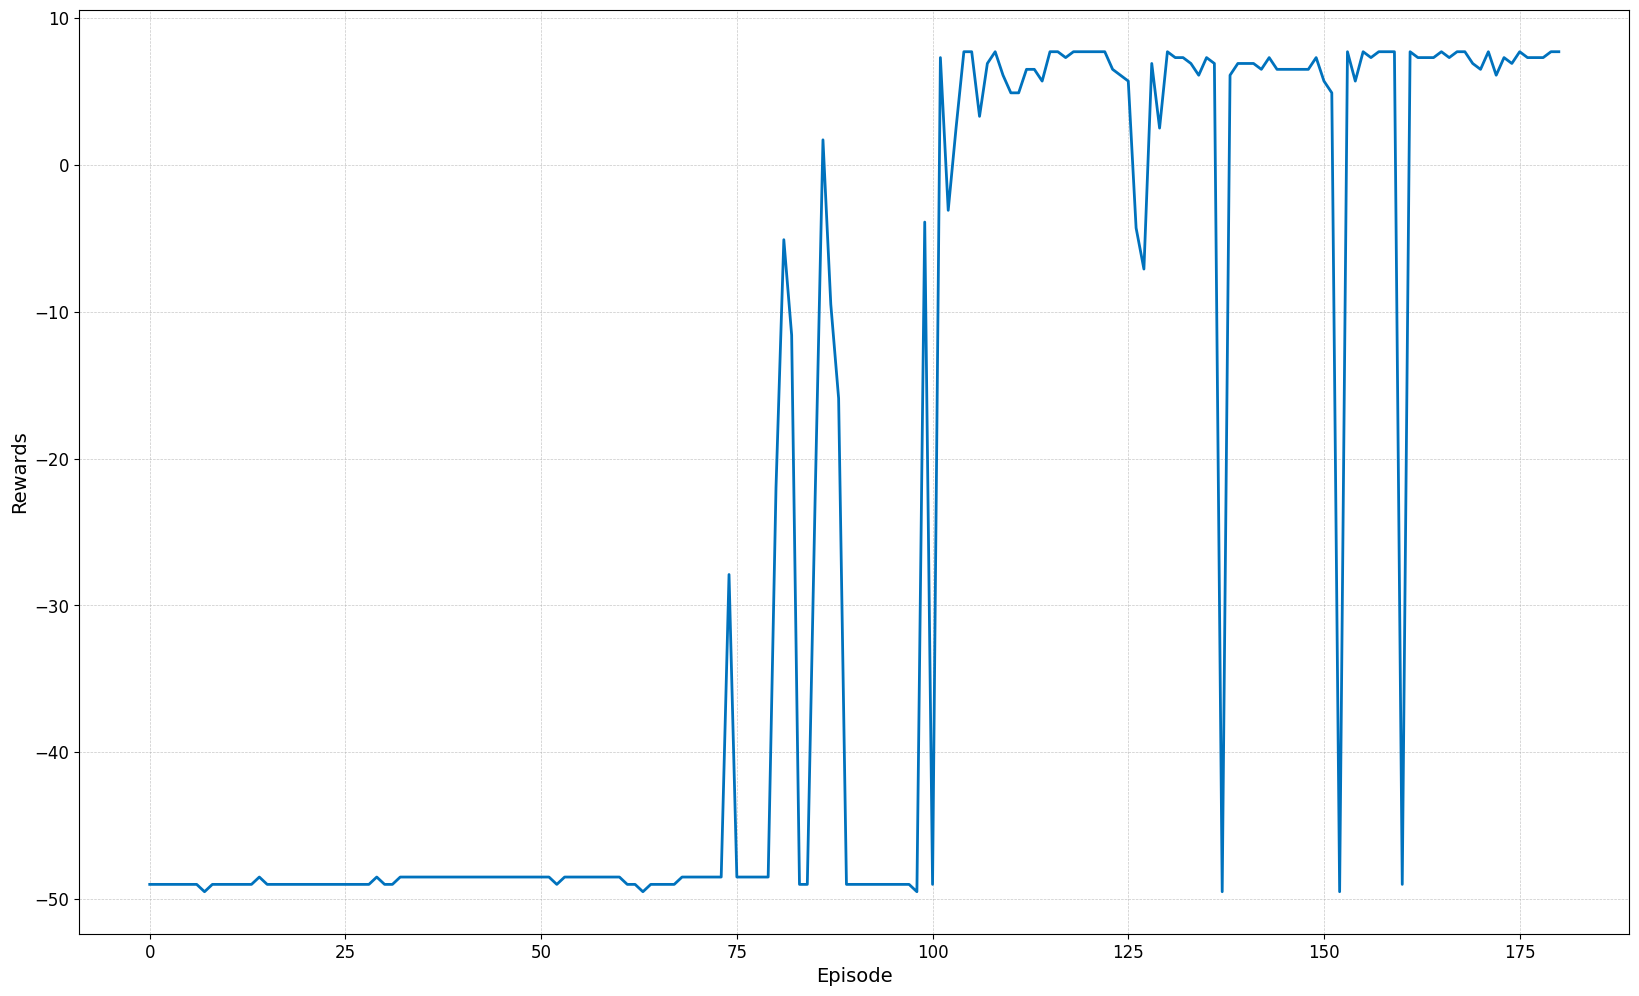

Policy has converged after 191 episodes! The final episode_rewards sum is 7.699999779462814, and the final duration is 11


2023/08/14 16:24:02 WARNING mlflow.utils.requirements_utils: Found torch version (1.13.1+cu117) contains a local version label (+cu117). MLflow logged a pip requirement for this package as 'torch==1.13.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved model!


2023/08/14 16:24:07 WARNING mlflow.utils.requirements_utils: Found torch version (1.13.1+cu117) contains a local version label (+cu117). MLflow logged a pip requirement for this package as 'torch==1.13.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/08/14 16:24:12 WARNING mlflow.utils.requirements_utils: Found torch version (1.13.1+cu117) contains a local version label (+cu117). MLflow logged a pip requirement for this package as 'torch==1.13.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved model!


2023/08/14 16:24:17 WARNING mlflow.utils.requirements_utils: Found torch version (1.13.1+cu117) contains a local version label (+cu117). MLflow logged a pip requirement for this package as 'torch==1.13.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Complete


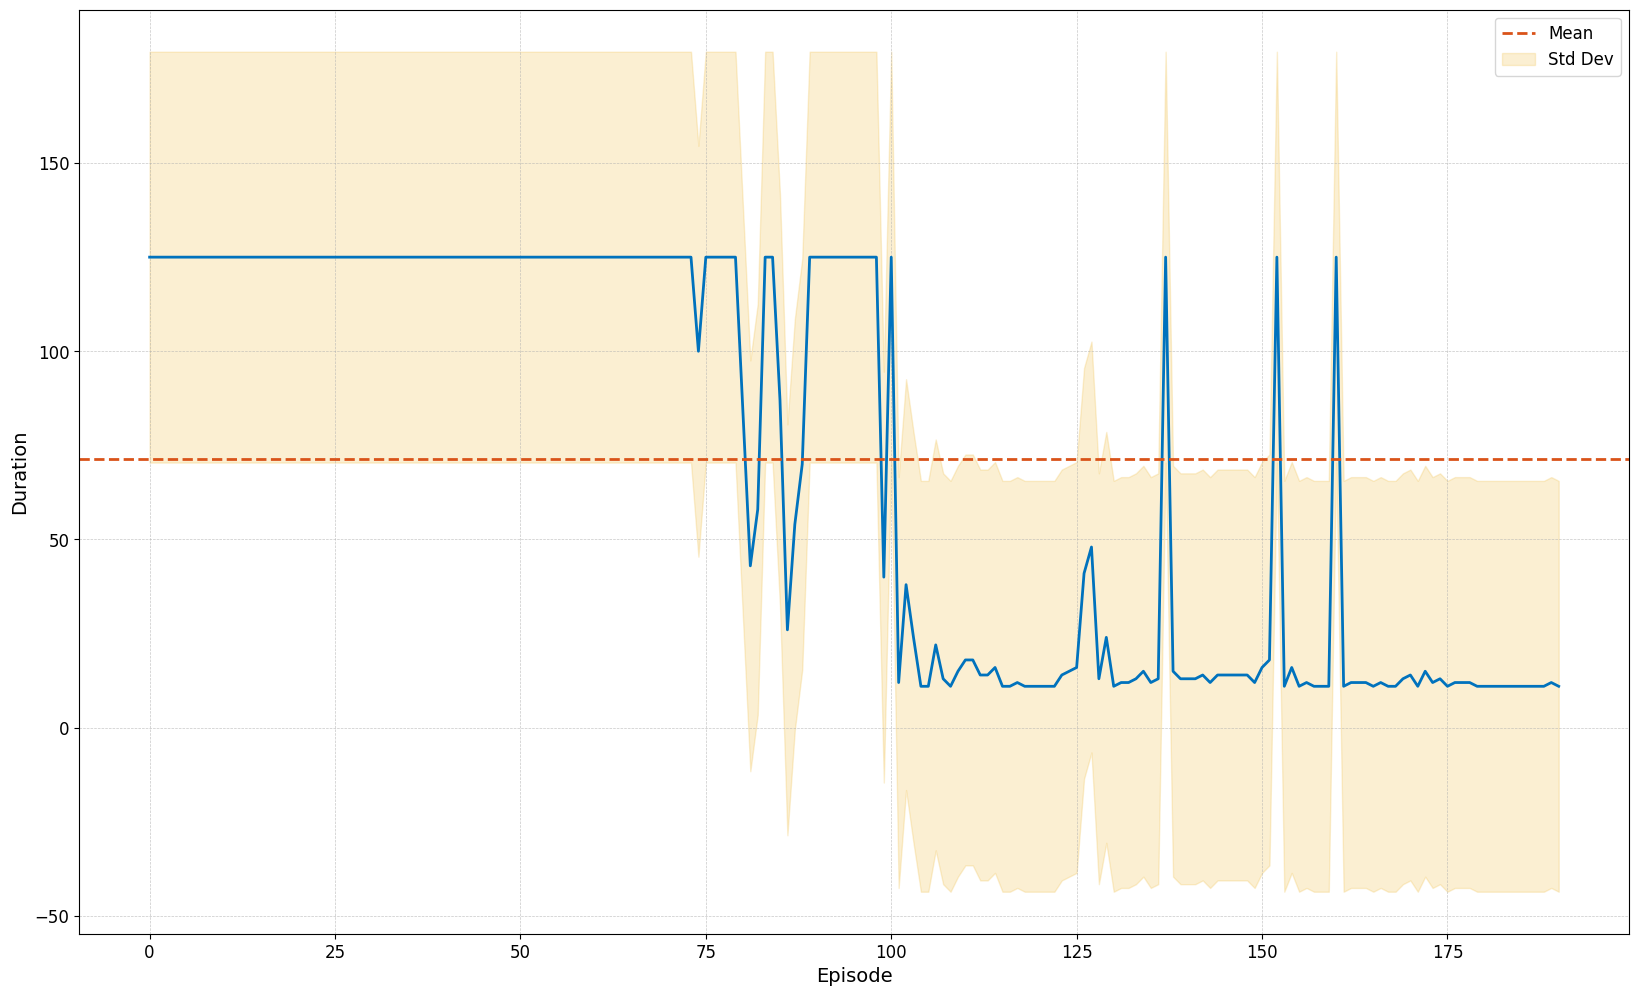

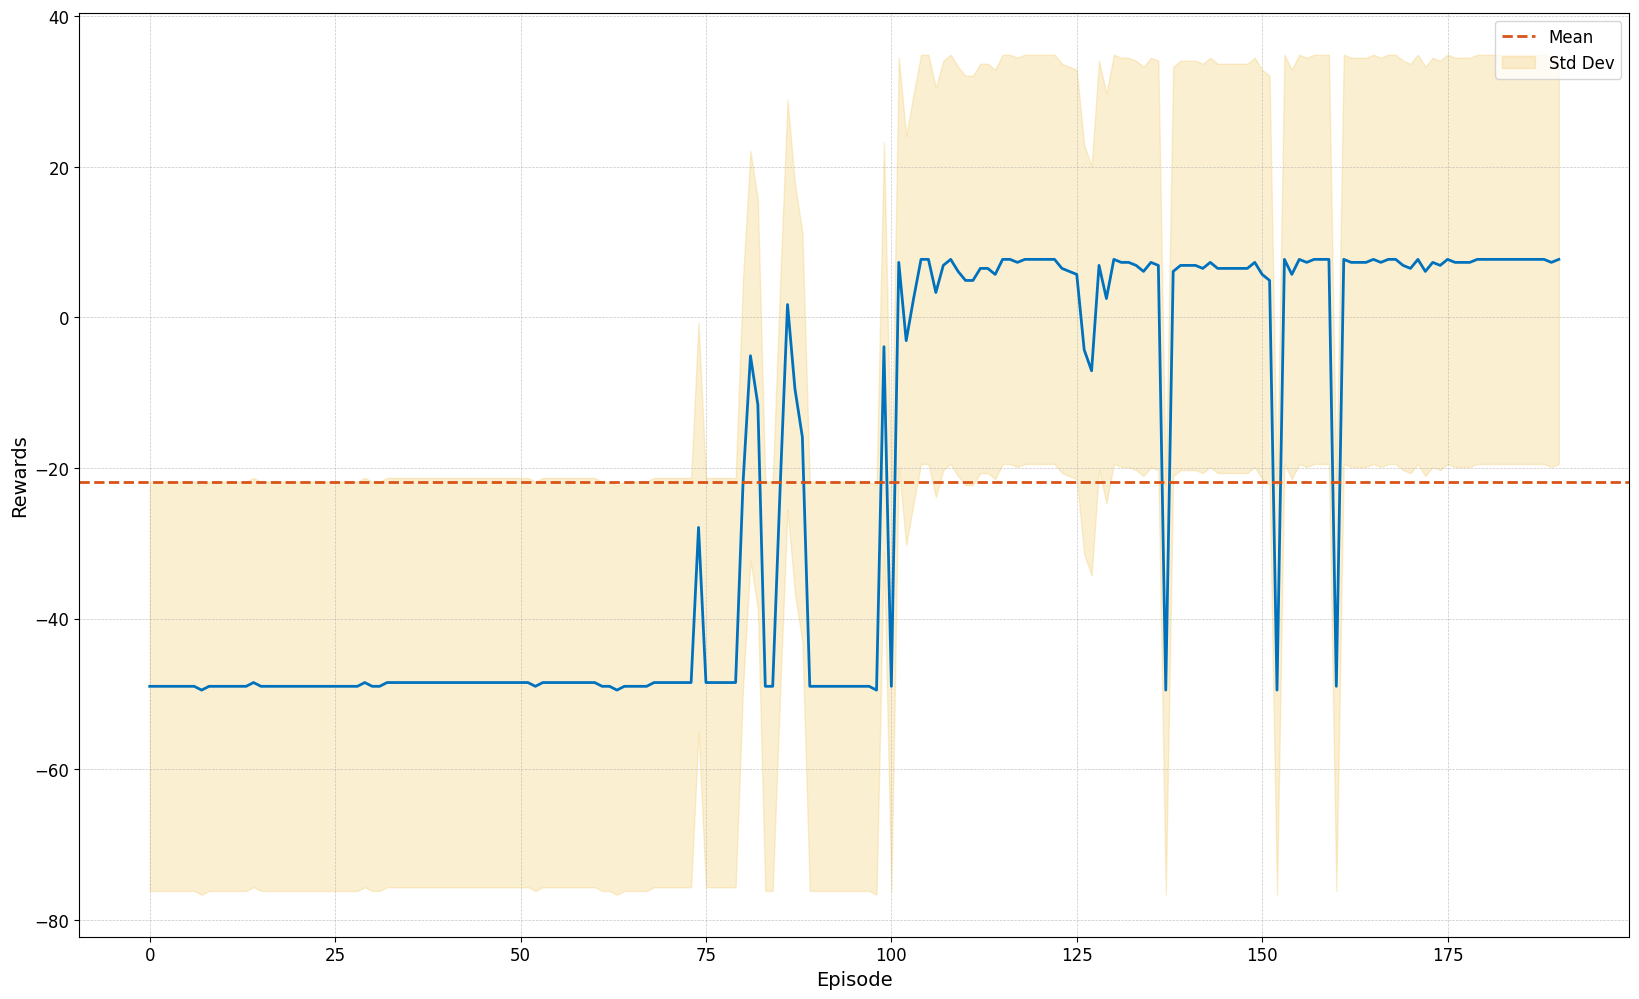

On episode 0, the average reward for the past 20 episodes is -49.0
The average duration of episode in the past 20 is 125.0


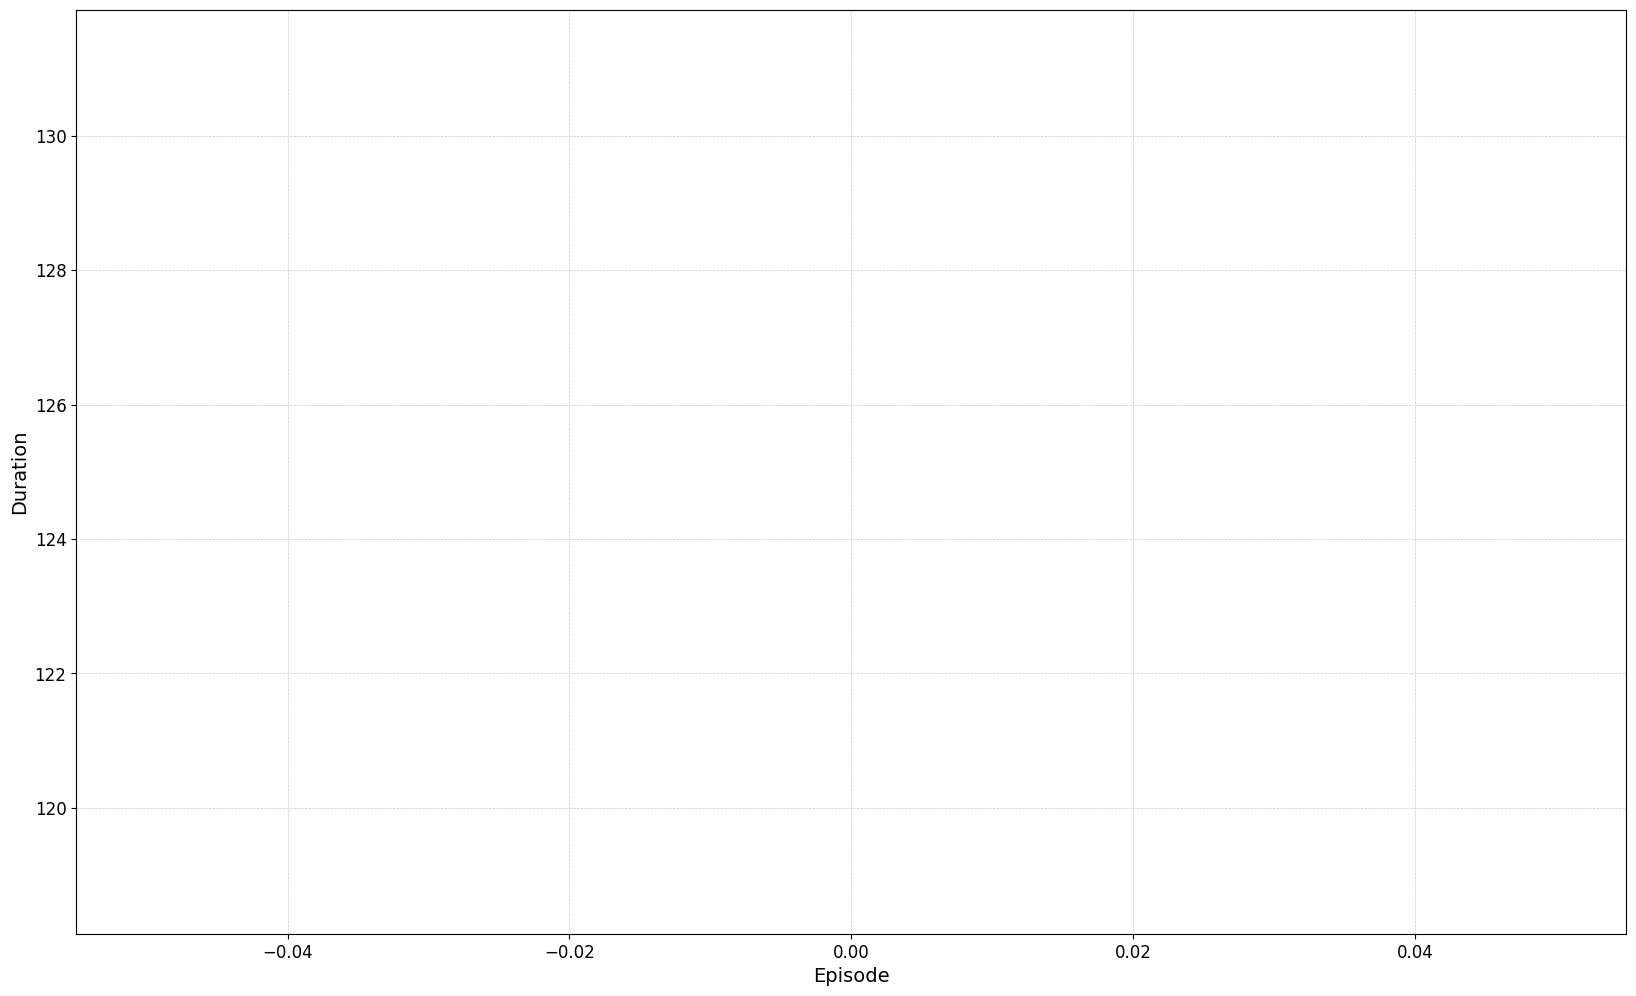

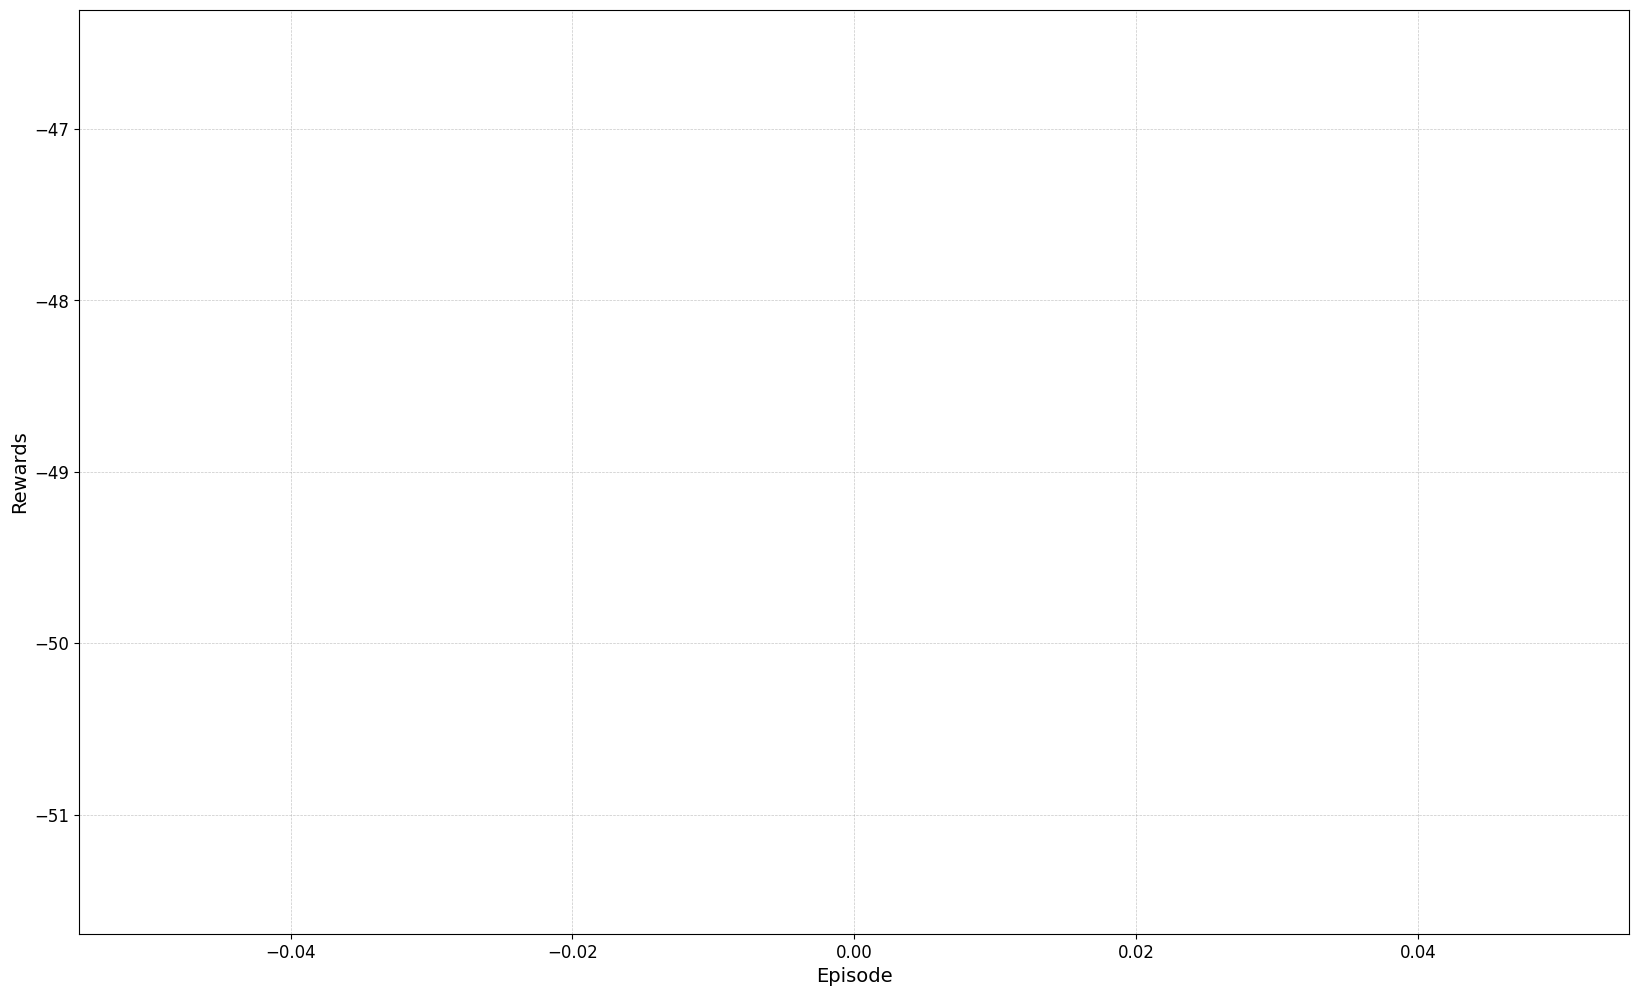

In [ ]:
# Experiments
optimizer_classes = ['AdamW', 'RMSprop']
lrs = [0.001, 0.0001]
epsilons = [0.1, 0.25, 0.6, 1.0]
reward_manipulation_options = [False, True]
batch_sizes = [128, 64, 32]
epsilon_decay_factor = 0.98
# seed_env = True

experiment_id = 2
for reward_manipulation in reward_manipulation_options:
    for lr in lrs:
        for optimizer_class in optimizer_classes:
            for batch_size in batch_sizes:
                for epsilon in epsilons:
                    epsilon_decay = epsilon in [0.6, 1.0]
                    run_name = f"{optimizer_class}_{lr}_{epsilon}_decay_{epsilon_decay}_reward_manip_{reward_manipulation}_{batch_size}"
                    with mlflow.start_run(experiment_id=experiment_id, run_name=run_name):
                        params = {
                            "optimizer_class": optimizer_class,
                            "lr": lr,
                            "epsilon": epsilon,
                            "epsilon_decay": epsilon_decay,
                            "": epsilon_decay_factor,
                            "batch_size": batch_size,
                            "reward_manipulation": reward_manipulation
                        }
                        if epsilon_decay:
                            params["epsilon_decay_factor"] = epsilon_decay_factor
                            mlflow.log_params(params)
                        else:
                            mlflow.log_params(params)
                        episode_durations, episode_rewards, policies_dict = run_experiment(run_name, optimizer_class, lr, epsilon, epsilon_decay, batch_size, reward_manipulation)
                        print('Complete')
                        plot_results(episode_durations, duration_mode=True, add_mean_and_std=True, save=True, run_name=run_name)
                        plot_results(episode_rewards, add_mean_and_std=True, save=True, run_name=run_name)
                        mlflow.log_artifact(f"results/{run_name}_Duration.png")
                        mlflow.log_artifact(f"results/{run_name}_Rewards.png")

## EX2 - PUSH & PULL - ONE BOX

In [ ]:
#=============== DO NOT DELETE ===============
sok_2 = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=500)
# ============================================

Observation space: Box(0.0, 255.0, (112, 112, 3), float32)
Action space: Discrete(13)
Player position:[2 3]
Box mapping: {(3, 5): (3, 4)}


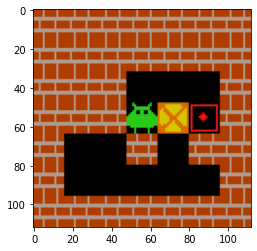

In [ ]:
screen = sok_2.render(mode='rgb_array')
plt.imshow(sok_2.render('rgb_array'))
observation, reward, done, _ = sok_2.step(1)
print_env_det(sok_2)

### EX2 - Video test

In [ ]:
env = sok_2
start_time = time.time()
done = False
iter = 0
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=10) as video:
  while (iter < 10) or not done:
    time_passed = int(time.time() - start_time)
    if done or time_passed > 3:
      break
    iter +=1
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    video.append_data(env.render(mode='rgb_array'))
embed_mp4(video_filename)

## EX3 - PUSH & PULL - TWO BOXES

In [ ]:
#=============== DO NOT DELETE ===============
sok_3 = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=2 ,max_steps=500)
# ============================================

Observation space: Box(0.0, 255.0, (112, 112, 3), float32)
Action space: Discrete(13)
Player position:[5 1]
Box mapping: {(1, 1): (4, 1), (3, 2): (4, 2)}


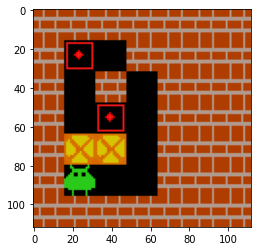

In [ ]:
screen = sok_3.render(mode='rgb_array')
plt.imshow(sok_3.render('rgb_array'))
print_env_det(sok_3)

### EX3 - Video test

In [ ]:
env = sok_3
start_time = time.time()
done = False
iter = 0
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=10) as video:
  while (iter < 10) or not done:
    time_passed = int(time.time() - start_time)
    if done or time_passed > 3:
      break
    iter +=1
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    video.append_data(env.render(mode='rgb_array'))
embed_mp4(video_filename)